# W261 Final Project: Predicting Criteo Click Through Rates (CTR)
## Julia Buffinton, Ram Iyer, Cameron Kennedy, Sharad Varadarajan
University of California, Berkeley, MIDS.  Fall 2018.

_Note, this notebook appears best in the "JupyterLab Light" theme (white background, found under the Settings menu). The dark theme makes some plot elements nearly impossible to see._

# 0. Executive Summary

Given a large dataset containing clicks on advertisements served by Criteo from Kaggle, we sought to use knowledge gained through W261 to build a scalable machine learning model to predict whether an advertisement would be clicked. We developed a "homegrown" implementation of logistic regression in Python using Spark and evaluated its performance using log loss and accuracy. Our best model achieved a log loss of 0.650 and accuracy of 0.645, better than chance but not near performance by the Kaggle competition winners. This encourages much further development of our approach to improve on both metrics.

# 1. Question Formulation

The goal of the below analysis is to answer the question, "Given a user and the page they are visiting, what is the probability that they will click on an ad?" We seek to predict the rate at which in site visitors will click on an advertisement served by Criteo. This analysis can be used by advertisers, Google, website owners, etc. to better inform the advertisements they display to increase revenue to the advertiser and, in this case, the retargeting company.

For our own development within the course, we'd like to answer the follow additional questions:
* What implementation decisions must we consider when building machine learning algorithms at scale? 
* How much do various preprocessing / feature engineering techniques improve accuracy while remaining viable at scale?

## 1.1 Analysis Metrics

To be practically useful, the algorithms developed will need to be scalable given the large volume of data (one week produces over 46 million records), and achieve an accuracy somewhat better than random guessing. 

**Scalability** will be considered excellent according to the criteria outlined in Lin & Dyer: if, given twice the amount of data, the same algorithm takes approximately twice as long to run. Additionally, if, given a cluster twice the size, the same algorithm should take approximately half the amount of time to run. This is very difficult to achieve in practice, because increasing the degree of parallelization increases communication costs. However, we will aim for this and consider scalability "good" if it approaches that performance.

**Accuracy** will be considered "acceptable" if the model can achieve at least 60% accuracy on a balanced data set (i.e., 10 percentage points better than random guessing). Though 60% is somewhat arbitrary, and though that accuracy may seem low, this target seems achievable and with data this size, 60% accuracy is likely sufficient to produce significant financial gain for stakeholders and alter decisions of which ads to serve to which users (it is outside the scope of this analysis to determine a more exact accetable level of accuracy).  That said, the team seeks to maximize accuracy through a variety of approaches.  

**Log loss** will be considered "acceptable" if the model can achieve performance between 0.693 and 0.445. The first value, 0.693, is essentially random guessing for binary logistic regression (when classes are evenly split). The second value, 0.445, is the log loss achieved by the winners of the Kaggle competition using this dataset. We will aim for a log loss of less than 0.6.

The Kaggle competion was evaluated using log loss, and the algorithm itself uses log loss as its optimization criterion, but the team included accuracy as well because it is more easily human understandable, answering the simple question, "what percent of outcomes did the algorithm correctly predict?".

Finally, the team also considered using other common classification metrics such as recall, precision, F1 score, etc., but decided against focusing on these measures, as they likely require domain knowledge outside of the scope of this analysis, as different stakeholders may favor optimizing either false positive or false negative rates.

## 1.2 Data Overview

To answer the questions posed above, we will use a dataset provided by Criteo and posted as a [Kaggle](https://www.kaggle.com/c/criteo-display-ad-challenge) competition in 2014. These data represent a portion of Criteo's traffic over seven days, ordered chronologically. Each row corresponds to a display advertisement that was served by Criteo. The dataset is approximately 11GB uncompressed, and consists of approximately 46 million rows of data with 40 columns:
* 1 column for the label, a binary field of 0s and 1s (1 indicates that an advertisement was clicked, 0 indicates it was not.)
* 13 columns of integer features, mostly count values (includes missing values)
* 26 columns of categorical features, hashed (include missing values)

The data contain no column labels, so we do not know what each feature represents, preventing any "common sense" feature engineering or manipulation of the data. 

# 2. EDA, Discussion of Challenges, and Required Preprocessing

In this section, we explore the data to learn more about its characteristics, informing choices for subsequent algorithm development.  This section also contains a significant amount of preprocessing that is required not only for the main algorithm, but also for the exploratory data analysis.  

The team explored a number of EDA choices, but in the interest of brevity, only the most interesting / relevant are discussed in this notebook.  Here is an outline of these EDA and preprocessing tasks:

1.	Notebook Initialization
2.	Data Splitting
3.	Data Parsing
4.	Null Value Exploration
5.	Numerical Data Distribution
6.	Normalization
7.	Null Value Imputation
8.	Categorical Data Exploration and Sparsity Investigation
9.	Class Balancing
10.	Omitted EDA Discussion

Finally, note the order of the EDA tasks is deliberately chosen to prevent misleading findings (e.g., numerical distribution is examined before imuputing null values to prevent skewing those results).

## 2.1 Notebook Initialization

We begin by loading our libraries and setting global variables.

In [35]:
%%capture
!pip install --upgrade google.cloud
!pip install --upgrade pandas
!pip install --upgrade networkx
!pip install --upgrade matplotlib
!pip install --upgrade pyspark
!pip install --upgrade seaborn
!pip install --upgrade pprint

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import pprint
%matplotlib inline

# for saving/loading data from disk
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import ArrayType
from pyspark.accumulators import AccumulatorParam

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
#General Parameters / Global Options, Formatting, etc.
pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [6]:
#Settings for cluster
spark
sc = spark.sparkContext

In [5]:
# #Please note that the settings below are tuned for a 16CPU machine with 60GB RAM - commented out for cluster

# # start Spark Session
# from pyspark.sql import SparkSession
# from pyspark import SparkConf
# from pyspark.accumulators import AccumulatorParam

# app_name = "final_project"
# master = "local[14]"

# # spark = SparkSession\
# #         .builder\
# #         .appName(app_name)\
# #         .master(master)\
# #         .config('spark.driver.memory','24g') \
# #         .config('spark.executor.memory','2g') \
# #         .getOrCreate()

# #Updated, deleting .master(master)
# spark = SparkSession\
#         .builder\
#         .appName(app_name)\
#         .config('spark.driver.memory','24g') \
#         .config('spark.executor.memory','2g') \
#         .getOrCreate()


# try:
#     sc = spark.sparkContext
# except:
#     print("Stopping Existing Spark Context before launching new one")
#     sc.stop()
#     sc = spark.sparkContext
    
# pp.pprint(spark.sparkContext._conf.getAll())

## 2.2 Data Splitting (Training, Validation, and Test Sets)

The next task is to split the data into train, validation, and test sets. In the dataset provided from Kaggle, there is both a training and test set. However, as the test set provided does not include labels, we cannot use it to test log loss and accuracy of our model. Since the data is chronologically ordered, the team preserved this order by splitting the training such that it occured before the validation and test data, specifically to prevent future data from predicting prior results.  The validation and test data was then split randomly in equal proportions.  Because the full dataset represents 7 days, the team chose to use the first $\frac{6}{7}$ of the data for training and the final $\frac{1}{7}$ for validation and testing in hopes of minimizing any intra-day distribution differences between the data sets (e.g., an alternate, hypothetical split that used the first 5.5 days of the week for training and the remaining 1.5 days for validation and testing would result in the training data having a lower proportion of afternoon, evening and nighttime activity compared to the validation and test sets).  This strategy makes the assumption that the data was roughly evenly distributed across days, which the team recognizes may be flawed, but because a date metric was not available, it seemed a reasonable alternative.

The team actually found the coding of this step to be most straightforward using the simple Linux `split` commmand to preserve the order of the data. The best alternative approach in Spark seemed to involve first numbering rows and then filtering based on row number, but the row numbering itself became challenging because Spark operations inherently split the data across nodes, thus losing its sense of order.  From a scalability perspective, this step only took a few minutes, even though it was not parallelly processed.  And a real-world implementation could avoid this step altogether by chronologically saving training, validation, and test sets as they come from the web server, making it irrelevant to scalability concerns.  Finally, because this step is performed in Linux, it comes first in our data processing, before loading the data into Spark, and is shown below.

The cell below contains original code used to split the data while maintaining chronological order as discussed above.  However, the team decided to save these split files and upload them up to our bucket for use on the cluster, as opposed to running the code below explicitly.  It is therefore commented out.

In [6]:
# #Split data into first 6 days (train) and last day (val & test)
# #We're making the assumption that the 7 days of data are roughly evenly distributed
# #Because we don't have any other way of knowing

# #Note we are not further splitting the Validation and Test data here,
# #because we want them to be randomly split, not sequentially split.

# #Set Split Point
# splitFracTrain_ValTest = 6/7

# #Used to speed up processing if data already split
# split_data = False

# if split_data:

#     #Timing
#     startTime = time.time()

#     #Get Total Data Length
#     dataLen = !wc -l < ./data/train.txt  #Returns list with single string e.g., ['number']
#     dataLen = int(dataLen[0])  #Change to integer
#     print('Total Lines of Data:', dataLen)
#     #dataLen = 45840617  #Should be this length

#     #Calculate Split Points
#     splitLineTrain_ValTest = int(dataLen * splitFracTrain_ValTest)
#     print('Splitting on Line', splitLineTrain_ValTest)

#     #Split Files
#     !split --lines {splitLineTrain_ValTest} --numeric-suffixes ./data/train.txt ./data/splitTrain-ValTest_ --verbose

#     print('Done!')
#     print('Elapsed Time:', time.time() - startTime, 'seconds.')

# else:
#     #Store data length if already split (not viable for a first run, but efficient for multiple runs)
#     dataLen = 45840617

Once split, the next cell loads the data into Spark for parallel compuatation.

In [7]:
#Load data as Spark RDDs
trainRDD = sc.textFile('gs://sharad-w261-bucket/dac/splitTrain-ValTest_00') 
splitValTestRDD = sc.textFile('gs://sharad-w261-bucket/dac/splitTrain-ValTest_01') 

#Randomize validation and test data
valRDD, testRDD = splitValTestRDD.randomSplit([0.5,0.5], seed = 1)

## 2.3 Data Parsing

With the data loaded, the next task is to initially parse the data, converting tab deliniation into separate data fields.  We also convert the first element to an integer label, the next 13 elements to integers (or `np.nan` if missing), and the final 26 elements are left as strings (including blank strings (`''`) for missing values).  This function outputs the string to a format of two nested tuples:  (label, (numerical fields, categorical fields))

Additionally, we implemented an option to take a small sample, useful for developing and testing calculations more quickly throughout the notebook.  It should be set to `False` to run the full dataset.

The cell below performs these tasks.

In [8]:
#Parse the data
def parse(line, num_numerical, num_categorical):
    """
      line is of format: "clicked_through \t <tab_sep_numeric_features> \t <tab_sep_categorical_features>"
                         there are a total of 13 numeric and 26 categorical features
                         
       output is of format: (clicked_through, (int features, categorical features))
                          : Here missing values are treated as zeros which needs to be handled better
    """
    
    numeric_fields = np.array([int(n) if n is not "" else np.nan
                              for n in line.split('\t')[1:num_numerical+1]])
        
    categorical_fields = line.split('\t')[num_numerical+1:]
    
    clicked_through = int(line.split('\t')[0])
    return(clicked_through, (numeric_fields,categorical_fields))

#Set our number of numerical and cateorical fields.
#This was provided with the data set, but can be adjusted for toy data
num_numerical = 13
num_categorical = 26

#Reduce data to improve run times for code testing purposes
take_sample = False
if take_sample:
    sample_size = 0.001
    trainRDD = trainRDD.sample(False, sample_size)
    valRDD = valRDD.sample(False, sample_size)
    testRDD = testRDD.sample(False, sample_size)

#Parse data
trainRDD = trainRDD.map(lambda x: parse(x, num_numerical, num_categorical)).cache()
valRDD = valRDD.map(lambda x: parse(x, num_numerical, num_categorical)).cache()
testRDD = testRDD.map(lambda x: parse(x, num_numerical, num_categorical)).cache()

Note that because Spark **lazily evaluates** data and we have only called transformations, it has not yet calculated any data because we have not performed Spark actions.

Finally, we inspect our data by returning a single row:

In [9]:
#Quick sample to see the form of our data
print(trainRDD.take(1))

[(0, (array([   1.,    1.,    5.,    0., 1382.,    4.,   15.,    2.,  181.,
          1.,    2.,   nan,    2.]), ['68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', '', '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16']))]


Now that our data is parsed, we can proceed to data exploration.

## 2.4 Null Value Exploration

The first data exploration task is to count the number of null fields.  We accomplish this task by implementing a handy "vector accumulator," which is similar to a standard Spark accumulator, but instead of counting a single value, it counts multiple items at the same time (1 for each column) in one single accumulator.

Note we separately count nulls for our training, validation, and test data to ensure there are no noteworthy differences in null counts across these three RDDs, an important consideration since they are chronologically ordered (if the final day of the data was on a weekend or perhaps a holiday, for example, it could show unrepresentative results).

In [10]:
#Count null values in each column

#Vector Accumulator!
class VectorAccumulatorParam(AccumulatorParam):
    """
    Vector accumulator object
    """
    
    def zero(self, value):
        return [0.0] * len(value)
    def addInPlace(self, val1, val2):
        for i in range(len(val1)):
             val1[i] += val2[i]
        return val1

#Set and broadcast the size of our vector accumulator
va_sizeB = sc.broadcast(num_numerical + num_categorical + 1)  #40

#Initialize the vector accumulator with all 0s
va = sc.accumulator(np.zeros(va_sizeB.value), VectorAccumulatorParam())
print('Initial Vector Accumulator Values:')
print(va.value)

def countNulls(rowIn, accum, num_numerical, va_sizeB):
    """
    Function to count null values for the entire data set.
    Desiged to be run with Spark's .foreach() action.
    
    Inputs:
        rowIn: A line from the RDD
            Format: (clicked_through, (int features, categorical features))
        accum: A vector accumulator object
        num_numerical {int}: Number of numerical items
        va_sizeB:  The broadcast value of the length of rowIn
        
    Output:
        None, but the accumulator object will contain the number of nulls
        for each column.
    """
    
    def accumulate(accum, num_item, va_sizeB):
        """
        Helper function to increment the accumulator.
        
        Inputs:
            accum:  A vector accumulator
            num_item:  The nuber of the item to accumulate
            va_sizeB:  Size of the accumulator (length of the vector)
            
        Output:  None, but increments the accumulator by 1 for the right column
        """
        a = np.zeros(va_sizeB.value)
        a[num_item] += 1
        accum += a
    
    #Check the labels (we now know there are no null labels, but included for completeness)
    if np.isnan(rowIn[0]):
        accumulate(accum, 0, va_sizeB)

    #Check numerical values
    for j, item in enumerate(rowIn[1][0]):
        if np.isnan(item):
            accumulate(accum, j+1, va_sizeB)
    
    #Check categorical values
    for j, item in enumerate(rowIn[1][1]):
        if item == '':
            accumulate(accum, j+num_numerical+1, va_sizeB)

            
#Timing
start_time = time.time()

#Run our null counting function
for i, RDD in enumerate([trainRDD, valRDD, testRDD]):
    
    #Reset accumulator
    va = sc.accumulator(np.zeros(va_sizeB.value), VectorAccumulatorParam())
    
    RDD.foreach(lambda x: countNulls(x, va, num_numerical, va_sizeB))
    numNulls = va.value

    row_count = RDD.count()
    print('\n\n', ['TRAINING NULLS:','VALIDATION NULLS:','TESTING NULLS:'][i], sep='')
    print(row_count, 'rows.')
    print('\nNumber of Null Values by Column:\n', numNulls)
    print('\nPercent of Null Values by Column:')
    for item in numNulls:
        print('{:.2%}'.format(item/row_count), end=' | ')
    print('\nElapsed Time: {:.0f} sec.'.format(time.time() - start_time))

Initial Vector Accumulator Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


TRAINING NULLS:
39291957 rows.

Number of Null Values by Column:
 [       0. 17931343.        0.  8409117.  8485728.  1014366.  8825669.
  1695533.    19709.  1695533. 17931343.  1695533. 30141088.  8485728.
        0.        0.  1351323.  1351323.        0.  4800184.        0.
        0.        0.        0.        0.  1351323.        0.        0.
        0.  1351323.        0.        0. 17249858. 17249858.  1351323.
 29982023.        0.  1351323. 17249858. 17249858.]

Percent of Null Values by Column:
0.00% | 45.64% | 0.00% | 21.40% | 21.60% | 2.58% | 22.46% | 4.32% | 0.05% | 4.32% | 45.64% | 4.32% | 76.71% | 21.60% | 0.00% | 0.00% | 3.44% | 3.44% | 0.00% | 12.22% | 0.00% | 0.00% | 0.00% | 0.00% | 0.00% | 3.44% | 0.00% | 0.00% | 0.00% | 3.44% | 0.00% | 0.00% | 43.90% | 43.90% | 3.44% | 76.31% | 0.00% | 3.44% | 43.90% | 43.90% |

The results above show that while some of our features contain no missing values, others contain a significant amount of missing data, greater than 70% for some fields.  It's easy to treat missing values as their own category for categorical data, but they will be partiularly challenging for numerical data and could have a material impact on both the choice of algorithm (e.g., tree based methods are more robust to missing values) and how we impute missing values.  Specific imputation strategies are discussed and calculated _after_ exploring numerical data distribution so as not to alter these findings.

The findings above also confirm that there are no major differences in percentage of null values between our training, validation, and test data.

## 2.5 Numerical Data Distribution

This section explores our numerical data input fields by looking at their histograms of their distribution, box plots of their distribution by label, and correlation with each other.  For these analyses, we take a small sample of our data, because distributions and correlations are robust to sampling, and because it significantly speeds up processing time.

### Histograms

We begin our analysis by inspecting histograms of our data:

In [11]:
#Create labels for numerical and categorical fields.
numeric_fields = ["click_through"] + ["I{}".format(d) for d in range(1,num_numerical+1)]
categorical_fields = ["C{}".format(d) for d in range(1,num_categorical+1)]  #Used later, but calculated here for consistency
print('Numeric Fields:', numeric_fields)
print('Categorical Fields:', categorical_fields)

#Sample the numerical fields
sample = np.array(testRDD.map(lambda x: np.append(x[0], [x[1][0]])) \
    .takeSample(False, 1000, seed=2018))

#Create dataframe of the numerical fields
sample_df = pd.DataFrame(np.array(sample), columns = numeric_fields)

Numeric Fields: ['click_through', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
Categorical Fields: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


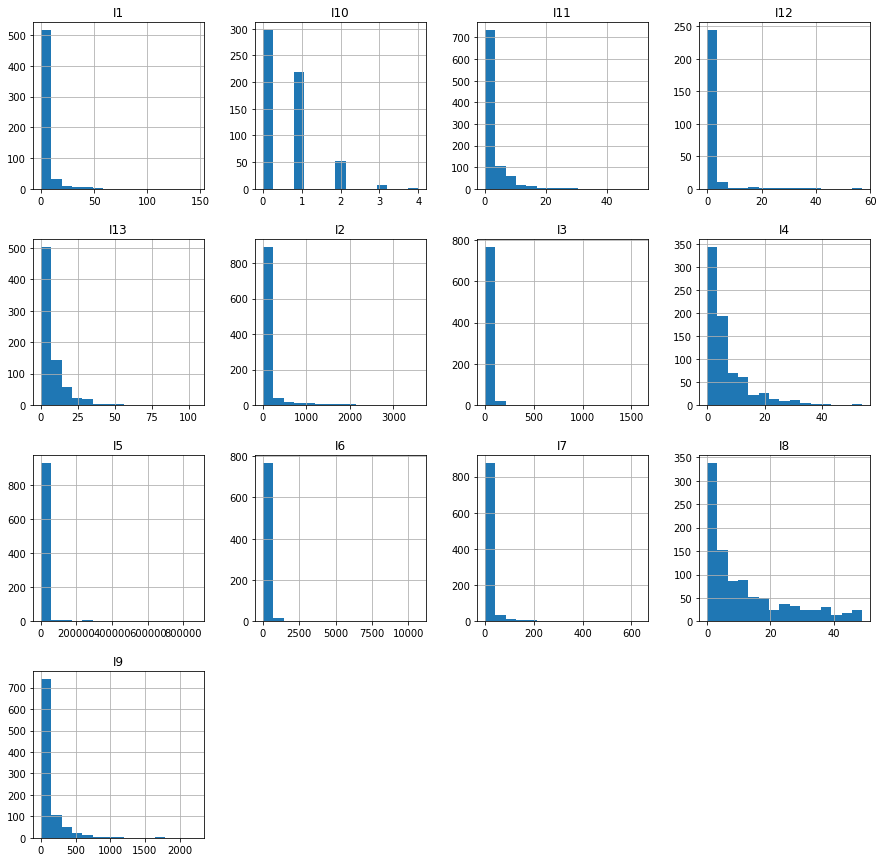

In [12]:
#Create histograms to inspect distribution of numerical variables
_ = sample_df[numeric_fields[1:]].hist(figsize=(15,15),bins=15)

The highly skewed distributions (long right tail) of every variable immediately jumps out as the most prominent characteristic of all the numerical data variables.  This skewing could be moderately problematic to logistic regression, because although with logistic regression, outliers have less effect on the cost function (e.g., $sigmoid(10) = 0.999954602131$ and $sigmoid(20) = 0.999999997939$:  despite doubling the input, the output is nearly the same), the magnitude of some of the enourmous outiers, even if multiplied by a low weight function, combined with the model learning its weights mostly from the predominant low-value data, these high values could dominate model output. This phenomenon may, however, be offset by the relative infrequency of high-value data.  Tree based methods may be more robust to skewed data, by consistently bucketing the outliers into a single 'huge' category.

From visual observation, it appears that all the data has a lower bound of zero.  We later discovered one variable (I2) had a few negative values, with a minimum as -3, but did not see this occurrence frequently enough to warrant taking action.

Finally, notice the scale of the values varies widely, from single digits to values in the hundreds of thousands.  Therefore, our model will almost certainly need to be normalized to prevent large value features from overpowering any models that employ gradient descent.

### Boxplots

Next, we inspect our data with boxplot distributions, split by the two classes:

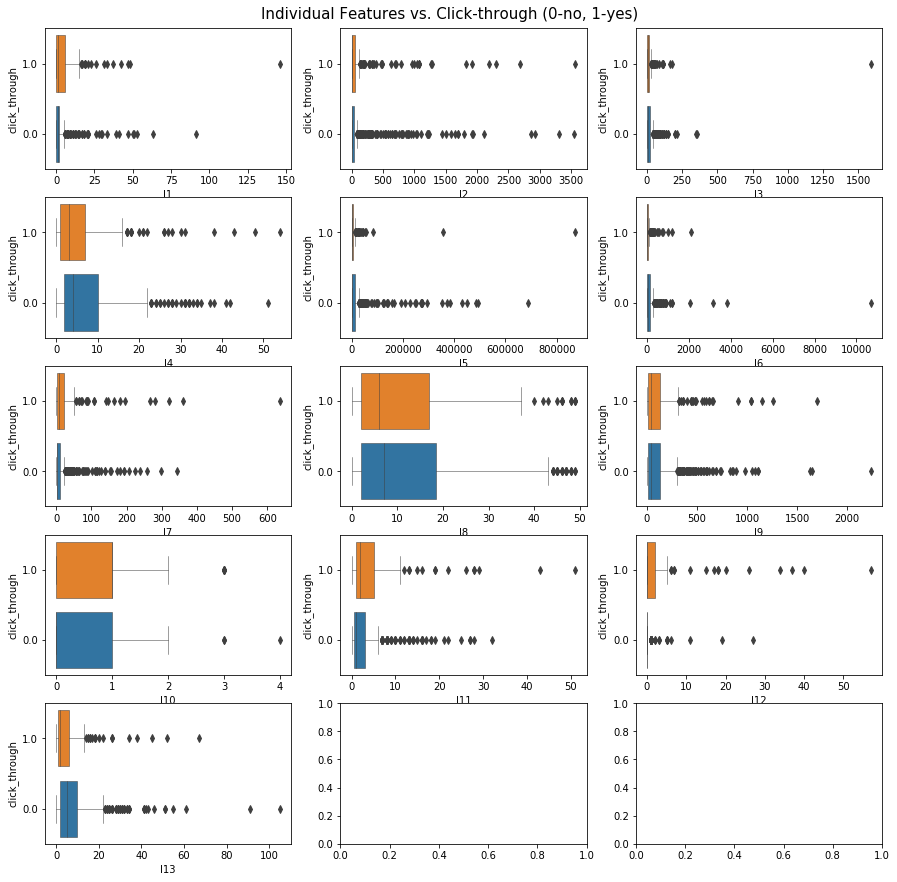

In [13]:
#Create box plots of the data, separated by class
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = sample_df['click_through']
for idx, feature in enumerate(numeric_fields[1:]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
    
fig.suptitle("Individual Features vs. Click-through (0-no, 1-yes)", fontsize=15, y=0.9)
plt.show()

Perhaps the biggest observation from these boxplots is that none of them, on their own, show any notably different distributions between the two classes.  This finding suggests that stronger predictive performance may only be obtained by modeling feature interactions both within the numerical variables, and between them and the categorical variables.

### Correlation Heatmap

Next, we look at the correlation between numerical variable pairs.

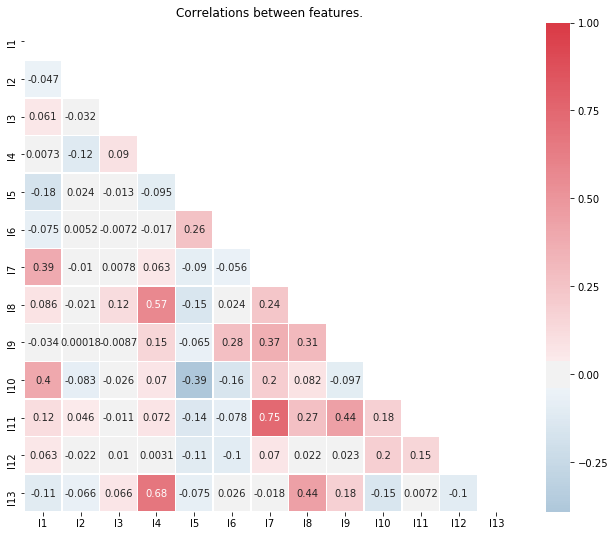

In [14]:
#Plot heatmap for correlations matrix
corr = sample_df[numeric_fields[1:]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True)
plt.title("Correlations between features.")
plt.show()

The correlation heatmap above shows a couple strong correlations among variable pairs (I4 with I13, and I7 with I11), but nothing so strong that it suggests removing a variable due to redundancy.

## 2.6 Numerical Data Normalization

To address the variation data among our numerical features discussed above, we normalized it by centering it to 0 (subtracting data from its mean) and scaling it to have a standard deviation of 1 (dividing by its standard deviation).

Because of the missing values, and because Spark does not have `nanmean` and `nanstd` calcluations like numpy does, our function below had to filter out the missing (`np.nan`) values manually.  To avoid memory overflow errors, each mean and standard deviation was calculated one variable at a time, resulting in a rather long run time.  From a scalability perspective, this may not be practical, espcecially if running on a much larger data set such as a year of advertising data (52 times bigger!).  An easy solution to this challenge would be to take a small sample of the data, which should not materially affect these statistics.

For this analysis, we chose to hardcode the data once calculated to save considerable processing time, though we recognize this strategy is flawed if used on new data sets.

We were also intentional to calculate the means and standard deviations on only the training data, and then use these statistics to adjust the validation and test data, so that the model does apply learnings in training to different distributions in the validation and test data.

In [15]:
#Normalization of integer variables
def normalize(inputRDD, featureMeansB=None, featureStdevB = None):
    """
        Normalize each row of the passed RDD's numeric fields, by centering
        (setting mean to 0) and scaling (setting standard deviation to 1).
        
        Inputs:
            inputRDD:  RDD of form (label,(numeric_features,categorical_features))
            featureMeansB:  Means to use for normalization.  Calculates means if "None".
            featureStdevB:  Stdevs to use for normalization.  Calculates stdevs if "None".
            
        Outputs:
            normRDD:  The normalized version of the RDD
            featureMeansB:  Broadcasted feature means (either calculated or input)
            featureStdevB:  Broadcasted standard dev's (either calculated or input)
    """
    if featureMeansB == None or featureStdevB == None:
        
        #Get a sample of the rows
        sampleInputRDD = inputRDD.sample(False, 0.0025).cache()
        
        #Establish placeholder lists for means and stdevs
        featureMeans, featureStdev = [], []
        
        #Loop through columns, filter out blanks, and compute means and stevs
        for i, _ in enumerate(sampleInputRDD.take(1)[0][1][0]):

            featureMeans.append(sampleInputRDD.map(lambda x: x[1][0][i]).filter(lambda x: not(np.isnan(x))).mean())
            featureStdev.append(sampleInputRDD.map(lambda x: x[1][0][i]).filter(lambda x: not(np.isnan(x))).stdev())

        #Broadcast means and stdevs
        featureMeansB = sc.broadcast(np.array(featureMeans))
        featureStdevB = sc.broadcast(np.array(featureStdev))
        
        print('Means:', featureMeansB.value)
        print('StDevs:', featureStdevB.value)
    
    #Compute normalized values by subtracting the mean and dividing by the stdev
    normRDD = inputRDD.map(lambda x: (x[0], ((x[1][0] - featureMeansB.value)/featureStdevB.value, x[1][1]))).cache()
        
    return normRDD, featureMeansB, featureStdevB

#Timing
start_time = time.time()

#Option to use pre-calculated normalizaiton stats, to save time
#Only set to true if not using a sample of data in cells above
calculate_norm_stats = True

if calculate_norm_stats:
    trainRDD, trainMeansB, trainStdevsB = normalize(trainRDD)
    
else:
    trainMeans = [3.51873593, 106.0503429, 26.55240198, 7.33277858, 
                   18666.19861997, 116.25734799, 16.14737952, 12.52957913,
                   104.83070491, 0.62221957, 2.69909008, 0.97365376, 8.22167611]
    trainStdevs = [9.48077093, 392.1246829, 385.32605138, 8.77786685,
                    69681.78719992, 366.81607243, 65.85527085, 16.55037044,
                    218.40343397, 0.6843051, 5.16681328, 5.54814884, 16.16078014]

    trainMeansB = sc.broadcast(np.array(trainMeans))
    trainStdevsB = sc.broadcast(np.array(trainStdevs))
    
    trainRDD,_,_ = normalize(trainRDD,trainMeansB,trainStdevsB)

valRDD,_,_ = normalize(valRDD,trainMeansB,trainStdevsB)
testRDD,_,_ = normalize(testRDD,trainMeansB,trainStdevsB)

print('\nElapsed Time: {:.0f} sec.'.format(time.time() - start_time))

Means: [    3.56027308   107.43466111    27.07126304     7.39901637
 18610.99937386   112.72888248    16.19574558    12.45246085
   103.35891995     0.62798092     2.66251127     0.93863833
     8.73526176]
StDevs: [    9.2650549    392.22480772   336.2536185      8.90114706
 68699.55535901   298.3924861     70.5385821     14.79371502
   221.14606237     0.68545619     5.17236148     4.62495481
    55.77129364]

Elapsed Time: 23 sec.


Here we see only a small difference using a tiny fraction of the data.
* Means ...
  * Using Full Data:   `__ [3.52, 106, 26.6, 7.33, 18666, 116, 16.1, 12.5, 105, 0.622, 2.70, 0.974, 8.22]`
  * Using Sample Data: `[3.40, 108, 26.2, 7.30, 18678, 115, 16.1, 12.5, 105, 0.617, 2.71, 0.888, 8.13]`
* StDevs ...
  * Using Full Data:   `__ [9.48, 392, 385, 8.78, 69681, 367, 65.9, 16.6, 218, 0.684, 5.17, 5.54, 16.2]`
  * Using Sample Data: `[8.53, 394, 326, 8.64, 68511, 339, 65.3, 14.2, 220, 0.682, 5.29, 4.12, 11.9]`

Since we already calculated the actual means and standard deviations for the full dataset, we use those in our analysis, but this comparison shows that sampling is a decent strategy to overcome the challenge of a large data set.

In [16]:
print(trainMeansB.value, trainStdevsB.value)

[    3.56027308   107.43466111    27.07126304     7.39901637
 18610.99937386   112.72888248    16.19574558    12.45246085
   103.35891995     0.62798092     2.66251127     0.93863833
     8.73526176] [    9.2650549    392.22480772   336.2536185      8.90114706
 68699.55535901   298.3924861     70.5385821     14.79371502
   221.14606237     0.68545619     5.17236148     4.62495481
    55.77129364]


## 2.7 Null Value Imputation

Although null value exploration was performed above for all variables, the team waited to impute null values until _after_ exploring the numerical values so as not to skew any results.  Conversely, it performed null value imputation _before_ the categorical variable analysis so that null values could be explicitly shown as 'missing' in those results.

The next cell converts null values in the data.  For categorical values, it simply replaces the blank string with `MISSING`. For numerical values, the team explored a few options:
* Replacing nulls with zeros (effectively replacing with means, since this step is performed after normalization).
* Replacing nulls with medians.
* Replacing nulls with double the maximum value in the variable, which will presumably cause worse performance for logistic regression due to model weights multiplying by a frequent number of these implausibly high values, but may perform better on tree methods by effectively bucketing them into a separate 'unknown' category.

Although all methods were tested, only the code for zeros value is shown in this notebook for brevity, though the results of all methods are shown in the Algorithm Implementation section.  If desired, alternate methods can be run by changing the value for `num_impute_type` in the cell below.

_Note, the values for medians and maximums that are hardcoded below were calculated separately but not shown to reduce notebook length._

In [17]:
#Convert nulls to other values 

#Numerical Options: 0 (mean), Median, Double
#Categorical: 'NULL')

def populateNulls(rowIn, num_impute_type):
    """
    Function to replace nulls with imputed values for numerical data 
    or 'MISSING' for categorical.
    
    Inputs:
        rowIn: Row from the RDD, of format (label, (numeric_fields,categorical_fields))
        num_impute_type: Values to use to replace missing numerical fields
        
    Output:
        Row of RDD, of format (label, (numeric_fields,categorical_fields))
    """
    
    #Convert numerical values
    numeric_fields = np.array([num_impute_type[i] if np.isnan(n) else n 
                               for i,n in enumerate(rowIn[1][0]) ])
    
    #Convert categorical values
    categorical_fields = ['MISSING' if n == '' else n 
                          for n in rowIn[1][1] ]

    return (rowIn[0], (numeric_fields,categorical_fields))

#Alternatives explored
zeros = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
medians = [-0.26566784, -0.26279994, -0.05333769, -0.37967978, -0.2373963,
           -0.2487823 , -0.18445569, -0.33410606, -0.30599658,  0.55206432,
           -0.32884681, -0.17549164, -0.26122972]
two_max = [516.4935913085938, 615.3348388671875, 155.65484619140625, 108.12881469726562, 
           376.95916748046875, 848.3016357421875, 781.8882446289062, 317.4294738769531, 
           131.5545654296875, 16.55251121520996, 30.596466064453125, 1224.109130859375, 561.43603515625]
twoMax = [2*i for i in two_max]

num_impute_type = zeros

trainRDD = trainRDD.map(lambda x: populateNulls(x, num_impute_type))
valRDD = valRDD.map(lambda x: populateNulls(x, num_impute_type))
testRDD = testRDD.map(lambda x: populateNulls(x, num_impute_type))

In [18]:
#Quick verification of results up to this point
print(trainRDD.take(1))

[(0, (array([-0.27633653, -0.27136137, -0.06563874, -0.83124302, -0.25078764,
       -0.36438211, -0.01695165, -0.7065474 ,  0.35108507,  0.5427321 ,
       -0.12808681,  0.        , -0.12076574]), ['68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', 'MISSING', '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16']))]


The output above verfies our numerical data was normalization, and missing values were converted as expected.

## 2.8 Categorical Data Exploration and Sparsity Investigation

Next, we determine the number of unique categories in each of the categorical variables.  For this task, we use the `.distinct()` transformation followed by the `.count()` action.  The results will provide a sense of the sparsity of the data.  If using one-hot encoding, each unique category becomes its own column, making the data significantly 'wider' that its initial 40 columns. And if the number of categories is very large, it will likely also need to be reduced to the most frequently found values.

To get accurate counts, the full data set is required (a sample will be ineffective for this task because it will miss a large number of unique categories).

In [19]:
 def count_unique_categoricals(fullRDDIn):
    """
    Function to count the number of unique categorical entries in each column.
    
    Input : RDD of format (label, (numerical_features,categorical_features))
            The categorical features are a list of 26 strings from 1-26
            
    Decription: In the first step we create tuples (column_number, feature_name)
                In the second step only the distinct (column_number, feature_name) tuples are retained
                Since we are only interested in feature counts, we then map to (column_name, distinct feature count) tuples
                Finally all the distinct feature counts are added up for each column with a reduceByKey
    """
    tuples = fullRDDIn.flatMap(lambda x: [(i+1, x[1][1][i]) for i in range(26)]) \
             .distinct() \
             .map(lambda x: (x[0],1)) \
             .reduceByKey(lambda x,y: x+y) \
             .collect()
    return tuples

start_time = time.time()
counts = count_unique_categoricals(trainRDD)
for count in counts:
    print("CATEGORICAL VARIABLE C{} - Unique Values: {}".format(count[0],count[1]))

print('\nElapsed Time: {:.0f} sec.'.format(time.time() - start_time))

CATEGORICAL VARIABLE C1 - Unique Values: 1460
CATEGORICAL VARIABLE C2 - Unique Values: 579
CATEGORICAL VARIABLE C3 - Unique Values: 8832328
CATEGORICAL VARIABLE C4 - Unique Values: 1965470
CATEGORICAL VARIABLE C5 - Unique Values: 305
CATEGORICAL VARIABLE C6 - Unique Values: 24
CATEGORICAL VARIABLE C7 - Unique Values: 12453
CATEGORICAL VARIABLE C8 - Unique Values: 633
CATEGORICAL VARIABLE C9 - Unique Values: 3
CATEGORICAL VARIABLE C10 - Unique Values: 89982
CATEGORICAL VARIABLE C11 - Unique Values: 5623
CATEGORICAL VARIABLE C12 - Unique Values: 7305771
CATEGORICAL VARIABLE C13 - Unique Values: 3181
CATEGORICAL VARIABLE C14 - Unique Values: 27
CATEGORICAL VARIABLE C15 - Unique Values: 14746
CATEGORICAL VARIABLE C16 - Unique Values: 4811892
CATEGORICAL VARIABLE C17 - Unique Values: 10
CATEGORICAL VARIABLE C18 - Unique Values: 5580
CATEGORICAL VARIABLE C19 - Unique Values: 2171
CATEGORICAL VARIABLE C20 - Unique Values: 4
CATEGORICAL VARIABLE C21 - Unique Values: 6183794
CATEGORICAL VARIABL

Here we see an enormous number of total unique categories, in the tens of millions. A dataset this wide is not scalable, as it creates a very large, very sparse matrix which must be multiplied to generate predictions and likely causes memory issues. Therefore, we will first need to find a solution to utilize the values in these categories without encountering memory issues - one common approach is to reduce the data by taking only the most frequently found categories. We explore this option is section 4.2.

## 2.9 Class Balancing

The final EDA task explores the balance between the two classes (0 and 1), implemented in the code below.

We intentionally positioned this preprocessing task after the rest of the EDA so as not to remove values before exploration.

In [19]:
#Discover class imbalance
def balanceCheck(RDDIn):
    """
    Function to count the number of rows with each label.
    
    Input:
        RDDIn: RDD of format (label, (numeric_fields,categorical_fields))
        
    Output:
        neg_count {int}:  Count of the negative (0) classes.
        pos_count {int}:  Count of the positive (1) classes.
        The function also prints these values.
    """
    
    neg_count = RDDIn.filter(lambda x: x[0]==0).count()
    pos_count = RDDIn.filter(lambda x: x[0]==1).count()
    print('Negative Count:', neg_count)
    print('Positive Count:', pos_count)
    print('Percent Positive: {:.2%}'.format(pos_count / (neg_count + pos_count)))
    
    return neg_count, pos_count

#Stack all 3 RDDs
fullRDD = trainRDD.union(valRDD).union(testRDD)

neg_count, pos_count = balanceCheck(fullRDD)

#Note we verified the distribution was similar across our splits, but it is commented out to save space
# balanceCheck(trainRDD)
# balanceCheck(valRDD)
# balanceCheck(testRDD)

Negative Count: 34095179
Positive Count: 11745438
Percent Positive: 25.62%


As we can see, the two classes are imbalanced, with the positive class representing only ~26% of the examples.

The code below rectifies this imbalance, reducing the number of negative classes such that two classes are in roughly equal proportion (Spark's `.sample()` is not perfectly precise, but it's close enough for this work).  Though reducing data can sometimes be problematic, because the resulting data still contains rougly 10 million training records, this choice retains ample training data to make good predictions.

Though not shown in the implementation below, our initial logistic regression using unbalaced classes quickly converged to predict all negative results, producing a meaningless 74% accuracy, which further justified the choice to balance classes.

Although we balanced the training data, we preserved the imbalance of the validation and test data to assess our model on the actual data provided.

In [20]:
#Balance Classes

#Note it stacks the two RDDs, so it's all negative first, then all positive
def balanceData(RDDIn, neg_count, pos_count, check=False):
    """
    Function to balance the classes by removing negative classes at random
    until the number of positive and negative classes are roughly equal.  
    Assumes negative classes > positive classes, and will not work properly otherwise.
    
    Inputs:
        RDDIn: RDD of format (label, (numeric_fields,categorical_fields))
        neg_count {int}:  Count of the negative (0) classes.
        pos_count {int}:  Count of the positive (1) classes.
        
    Output:
        RDD of format (label, (numeric_fields,categorical_fields)),
            having removed a portion of negative classes.
    """

    posClassRDD = RDDIn.filter(lambda x: x[0]==1)
    negClassRDD = RDDIn.filter(lambda x: x[0]==0).sample(False, pos_count/neg_count, seed = 2018)    
    outputRDD = negClassRDD.union(posClassRDD).cache()

    #Math check. Set to False for full data as this is computationally expensive
    if check:
        print('Check')
        print('Pos Count:', outputRDD.filter(lambda x: x[0]==1).count())
        print('Neg Count:', outputRDD.filter(lambda x: x[0]==0).count())
        
    return outputRDD

trainRDD = balanceData(trainRDD, neg_count, pos_count, check=False)
valRDD = balanceData(valRDD, neg_count, pos_count, check=False)
testRDD = balanceData(testRDD, neg_count, pos_count, check=False)

## 2.10 Omitted EDA

As mentioned in the introduction to this section, the team also performed other EDA but is not showing those results here for report brevity.  They are as follows:

* Count, mean, and quartiles of all numerical variables.
* A scatterplot matrix of numerical variables, split by class.
* Histograms of most frequent items in categorical variables, split by class.
* Numerous data inspections to debug and verify functions were working as expected.

In [23]:
#Transform the data to Spark dataframes in preparation for saving
schema = StructType([StructField('Click_through',        IntegerType(),                 False),
                     StructField('Numeric_features',     ArrayType(FloatType(),True)  , True),
                     StructField('Categorical_features', ArrayType(StringType(), True), True)])


train_df = spark.createDataFrame(trainRDD.map(lambda x: (x[0],x[1][0].tolist(),x[1][1])),schema)
val_df  = spark.createDataFrame(valRDD.map(lambda x: (x[0],x[1][0].tolist(),x[1][1])),schema) # JB ADDED - RAM DID NOT HAVE VALRDD
test_df  = spark.createDataFrame(testRDD.map(lambda x: (x[0],x[1][0].tolist(),x[1][1])),schema)

In [24]:
#Save the files
train_df.write.mode("overwrite").format("parquet").save("gs://sharad-w261-bucket/dac/train-normalized.parquet")
del train_df
val_df.write.mode("overwrite").format("parquet").save("gs://sharad-w261-bucket/dac/val-normalized.parquet")
del val_df
test_df.write.mode("overwrite").format("parquet").save("gs://sharad-w261-bucket/dac/test-normalized.parquet")
del test_df

# 3. Algorithm Explanation

We will implement binary logistic regression to answer the question we posed above. The team feels that binary logistic regression is an appropriate choice, given the context of the problem we would like to solve. Binary logistic regression outputs the probability that a given input point belongs to one of two classes. Specifically, for the Criteo CTR dataset, our given input would be a vector of values representing the original 39 features (depending on feature engineering decisions made, this will look different from what was provided from Kaggle), and the two classes would be "click ad" (1) or "not click ad" (0). Therefore, we can describe a logistic regression model in this context as predicting the probability that a given input for 39 features results in an ad being clicked. 

To demonstrate how binary logistic regression can be used to solve a problem like CTR, the team designed a simple example below, and will walk through the math without any code.

 
## 3.1 Toy Example Introduction

                                 TRAINING SET 

| Label	| I0 | I1 | I2 | C0 |                                  
| --- | --- | --- | --- | --- |                 
| 1	| 8 |	1|	10 |	John |                        
| 1	| 0 |	0|	7 |	Sara |
| 1	| "" |	2 |	7 |	"" |
| 0 |	7 |	9 |	2 |	Jane |
| 0	| 0 |	10 |	1 |	John |
| 0	| 5 |	9 |	1 |	Jane |


                                 TEST EXAMPLE

| Label	| I0 | I1 | I2 | C0 |  
| --- | --- | --- | --- | --- |
| ?	| 0 |	10 |	6 |	John |


The training set above includes five rows of data, each of which comprises a label with a binary output (i.e., whether a user clicks on the ad), three integer features, and one categorical feature. We will use logistic regression to quantify how each of the features influence our outcome, specifically by assigning weights to each of the features and then incrementally adjusting them until we feel confident in the model's ability to predict on new data. However, before we can dive into the math, there are some pre-processing steps we must take before applying an ML algorithm like logistic regression to the data we have.

## 3.2 Data Preparation

The first step is imputing the null values in our dataset, as a logisitic regression model cannot handle missing data as an input. We identify two issues for logistic regression from the training set in row 3: a missing integer value for feature `I0` and a missing categorical value for feature `C0`. For filling `I0`, there are multiple imputation options we could consider such as:  

>1) Eliminating the rows that include any null values  
>2) Replacing the null values with a fixed value, such as 0, or even with the median value for the respective feature  
>3) Designing a linear regression model that fills the null value based on the other feature values (excluding the label)

Since the team decided to impute integer values with 0's for the full dataset, we will take a similar approach for this example. For filling `C0`, we have some imputation options as well:

>1) Eliminating the rows that include any null values  
>2) Replacing the null values with the most common category for the respective feature  
>3) Binning the null values together into their own category for the respective feature

Since the team binned the nulls together into its own category for the full dataset, we will take a similar approach for this example. Our training data now becomes:

| Label	| I0 | I1 | I2 | C0 |                                  
| --- | --- | --- | --- | --- |                 
| 1	| 8 |	1|	10 |	John |                        
| 1	| 0 |	0|	7 |	Sara |
| 1	| 4 |	2 |	7 |	nullValC0 |
| 0 |	7 |	9 |	2 |	Jane |
| 0	| 0 |	10 |	1 |	John |
| 0	| 5 |	9 |	1 |	Jane |

The final pre-processing step is one-hot encoding our categorical variables. The two typical approaches to handling categorical features for logistic regression are one-hot encoding and label encoding. In our case, our only option is one-hot encoding, because Label-encoding our features would result in our categorical variable being treated as a numeric feature; this is problematic because it assumes some order to the categories, as opposed to treating them as nominal. Given our limited understanding of what the categories in our dataset mean, this would be inappropriate. Therefore, we one-hot encode so that we can preserve the nominal relationship between categories while using them in an ML model. Our training data now becomes:

| Label	| I0 | I1 | I2 | John | Sara | C0_NULL | Jane |                                
| --- | --- | --- | --- |  --- | --- | --- | --- |                
| 1	| 8 |	1|	10 |	1 |	0|	0 |	0 |                        
| 1	| 0 |	0|	7 |	0 |	1|	0 |	0 |
| 1	| 4 |	2 |	7 |	0 |	0|	1 |	0 |
| 0 |	7 |	9 |	2 |	0 |	0|	0 |	1 |
| 0	| 0 |	10 |	1 |	1 |	0|	0 |	0 |
| 0	| 5 |	9 |	1 |	0 |	0|	0 |	1 |

## 3.3 Logistic Regression Model

Now that our pre-processing is complete, we can start setting up our logistic regression model. As mentioned earlier, we will use logistic regression to quantify how each of the features influence our outcome, specifically by assigning weights ($\beta$ values below) to each of the features:

$y_t = \beta_0 + \beta_1*I0+ \beta_2*I1+ \beta_3*I2 + \beta_4*John + \beta_5*Sara + \beta_6*nullValC0 + \beta_7*Jane $          

In the equation above, $\beta_0$ represents the intercept (i.e., the output value when all of the other feature weights are at 0) and $\beta_1$ through $\beta_7$ represent the weight/importance that each feature has in contributing to our output $y$. In this equation, however, $y_t$ does not represent the probability that a user clicks, because $y_t$ is unbounded; theoretically it could approach infinity with high enough weights or values for our features. For logistic regression, we need to apply a transformation to $y_t$ to bound our output between 0 and 1 so that it truly represents a probability. This is accomplished by applying a sigmoid transformation to $y_t$:

$ P(Click) = \hat{y} = \Large \frac{1}{1+e^{-y_t}}$

From the two equations above, we can declare that applying a sigmoid transformation to the weighted sum of our input features is the predicted probability of a user clicking an ad. Next, we will have to obtain the weights for each input feature. This can be done by first making an educated guess, applying the model with those weights, checking how well it performs and making adjustments to the weights based on its errors, and then repeating the process, as described below. 

## 3.4 Log Loss and Gradient Descent

We start by making an educated guess based on the mean number of clicks in our training set:

$GUESS = \Large \frac{NumClicks_{train}}{N_{train}} = 3/6 = 0.5$

Plugging this into our sigmoid function:

$ P(Click) = 0.5 = \Large \frac{1}{1+e^{-y_t}}$  
$y_t = 0$

Therefore, ignoring the impact on prediction from any features, we can initialize all of our $\beta$ parameters as 0:

$y_t = 0 + 0*I0+ 0*I1+ 0*I2 + 0*John + 0*Sara + 0*nullValC0 + 0*Jane $

All things considered, this is still just an educated guess and our algorithm would perform poorly if we were finished at this step. We do this simply to iniatialize our beta values, and then we will iteratively adjust these weights using gradient descent. 

To understand gradient descent, we must first understand how we quantify the quality of our model while its being trained. For logistic regression, the metric of interest is known as the log loss:

\begin{equation}
LogLoss = J(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}(-\boldsymbol{y} \cdot log(\hat{\boldsymbol{y}}) - (1-\boldsymbol{y}) \cdot log(1- \boldsymbol{\hat{y}}))
\end{equation}

where $m$ is the number of rows in our training data, $y$ is the label for the current training example denoting whether the user actually clicked on the ad or not (1 or 0), and $\hat{y}$ is the the predicted probability of the user clicking on that ad for the current training example. Put simply, we are passing each example in our training data through our logistic regression model and calculating how different the predicted probability compares to the actual label. We sum up the differences for each example in our training data and take the average. We denote this result as the training log loss for our model. Since each training sample is passed through our logistic regression model, it is evident that our training log loss is significantly impacted by the values of each $\beta$ parameter. This is where gradient descent comes into play!

Gradient descent is an iterative process that guides us in optimizing the weights for each of our features, specifically by minimizing the log loss we discussed above:

\begin{equation}
  Gradient = \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}\boldsymbol{x'} \cdot (\boldsymbol{\hat{y}} - \boldsymbol{y})
\end{equation}

where $x'$ is our feature vector for the current row in our training data, $y$ is the label for the current training example denoting whether the user actually clicked on the ad or not (1 or 0), and $\hat{y}$ is the the predicted probability of the user clicking on that ad for the current training example. Essentially, for each iteration of gradient descent, we are computing the rate of change of our log loss with respect to each weight in our model. Since our log loss function is convex, we can use this calculated rate of change to adjust our model weights, with the goal of moving closer to minimizing our log loss before beginning the next iteration of gradient descent:

$newModel = currentModel - learningRate * Gradient$

Regarding $learningRate$, with each iteration through our training data we get an idea of the rate of change for loss. This enables us to make an informed update to our model parameters, which can be thought of as taking a step down the error surface. The size of this step is known as the learning rate. There are tradeoffs when setting the learning rate. If we have a high learning rate, we take larger steps down the error surface, which can be more time-efficient as there are fewer iterations through the data to find optimal paramters. However, a high learning rate risks the possibility of overshooting the lowest point since the slope of the hill can change at any point and we are not recalculating the gradient as often. If we have a low learnng rate, we take smaller steps, which could be more time-consuming to find optimal paramters. However, our steps are more precise as we are recalculating the gradient more frequently - this means we are less likely to overshoot the minimum.

After calculating our $newModel$ with gradient descent, we can evaluate our updated model on a heldout dataset to get a sense for how well our model generalizes. However, we will almost definitley need to run more iterations of gradient descent to better optimize our model before getting more accurate predictions.

## 3.5 Logistic Regression with Gradient Descent Calculations for Toy Example 
Below, our team has computed the math by hand for a single iteration of gradient descent on our toy example:

**Initial model:**  
$y_t = 0 + 0*I0+ 0*I1+ 0*I2 + 0*John + 0*Sara + 0*nullValC0 + 0*Jane$

currentModel = $[ 0.0,  0.0, 0.0,  0.0,  0.0,  0.0,  0.0, 0.0]$


**Baseline Log-Loss:**  
Each example will have a $\hat{y}$ of 0.5 because all of our feature weights are 0 for our initial model.

$Row1 Loss = -1 * log(0.5) - (1-1)*log(1-0.5) = 0.693$  
$Row2 Loss = -1 * log(0.5) - (1-1)*log(1-0.5) = 0.693$  
$Row3 Loss = -1 * log(0.5) - (1-1)*log(1-0.5) = 0.693$  
$Row4 Loss = 0 * log(0.5) - (1-0)*log(1-0.5) = 0.693$  
$Row5 Loss = 0 * log(0.5) - (1-0)*log(1-0.5) = 0.693$  
$Row6 Loss = 0 * log(0.5) - (1-0)*log(1-0.5) = 0.693$  

$LogLoss = 1/6 * 6 * 0.693 = 0.693$

**Baseline Prediction on Test Example:**  
Our test prediction should be a probability of 0.5 since all of our weights are 0 (aside from the bias) for our intial model.
$P(Click) = sigmoid(0 + 0*0+ 0*10+ 0*6 + 0*1 + 0*0 + 0*0 + 0*0) = sigmoid(0) = 0.5$

**Gradient Descent (learningRate of 0.2):**  
Each example will have a $\hat{y}$ of 0.5 because all of our feature weights are 0 for our initial model.

$Row1 Gradient = [1, 8, 1, 10, 1, 0, 0, 0] * (0.5 - 1) = [-0.5, -4, -0.5, -5, -0.5, 0, 0, 0]$  
$Row2 Gradient = [1, 0, 0, 7, 0, 1, 0, 0] * (0.5 - 1) = [-0.5, 0 ,0, -3.5, 0, -0.5, 0, 0]$  
$Row3 Gradient = [1, 4, 2, 7, 0, 0, 1, 0] * (0.5 - 1) = [-0.5, -2, -1, -3.5, 0, 0, -0.5, 0]$  
$Row4 Gradient = [1, 7, 9, 2, 0, 0, 0, 1] * (0.5 - 0) = [0.5, 3.5, 4.5, 1, 0, 0, 0, 0.5]$  
$Row5 Gradient = [1, 0, 10, 1, 1, 0, 0, 0] * (0.5 - 0)= [0.5, 0, 5, 0.5, 0.5, 0, 0, 0]$  
$Row6 Gradient = [1, 5, 9, 1, 0, 0, 0, 1] * (0.5 - 0)= [0.5, 2.5, 4.5, 0.5, 0, 0, 0, 0.5]$ 

Sum of partial gradients $= [0.0, 0.0, 12.5, -10.0, 0.0, -0.5, -0.5, 1.0]$  
Gradient $= 1/6* [0.0, 0.0, 12.5, -10.0, 0.0, -0.5, -0.5, 1.0] = [0.0, 0.0, 2.083, -1.667, 0.0, -0.083, -0.083, 0.167]$

**New Model:**  

newModel = currentModel - learningRate * Gradient

newModel = $[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] - 0.2 * [0.0, 0.0, 2.083, -1.667, 0.0, -0.083, -0.083, 0.167]$  
newModel = $[ 0.0,  0.0, -0.4166,  0.3334,  0.0,  0.0166,  0.0166, -0.0334]$
$y_t = 0.0 + 0*I0- 0.4166*I1+ 0.3334*I2 + 0*John + 0.0166*Sara + 0.0166*nullValC0 - 0.0334*Jane $

We will repeat this process to calculate log loss based on the new weights obtained through the first iteration of gradient descent, to hopefully improve (minimize) our log loss. 

**New Model Log Loss**

$Row1 Prediction = sigmoid(0.0 + 0*8- 0.4166*1+ 0.3334*10 + 0*1 + 0.0166*0 + 0.0166*0 - 0.0334*0) = 0.949$  
$Row2 Prediction = sigmoid(0.0 + 0*0- 0.4166*0+ 0.3334*7 + 0*0 + 0.0166*1 + 0.0166*0 - 0.0334*0) = 0.913$  
$Row3 Prediction = sigmoid(0.0 + 0*4- 0.4166*2+ 0.3334*7 + 0*0 + 0.0166*0 + 0.0166*1 - 0.0334*0) = 0.820$ 
$Row4 Prediction = sigmoid(0.0 + 0*7- 0.4166*9+ 0.3334*2 + 0*0 + 0.0166*0 + 0.0166*0 - 0.0334*1) = 0.042$  
$Row5 Prediction = sigmoid(0.0 + 0*0- 0.4166*10+ 0.3334*1 + 0*1 + 0.0166*0 + 0.0166*0 - 0.0334*0) = 0.021$  
$Row6 Prediction = sigmoid(0.0 + 0*5- 0.4166*9+ 0.3334*1 + 0*0 + 0.0166*0 + 0.0166*0 - 0.0334*1) = 0.031$   

$Row1 Loss = -1 * log(0.949) - (1-1)*log(1-0.949) = 0.0523$  
$Row2 Loss = -1 * log(0.913) - (1-1)*log(1-0.913) = 0.091$  
$Row3 Loss = -1 * log(0.820) - (1-1)*log(1-0.820) = 0.198$  
$Row4 Loss = 0 * log(0.042) - (1-0)*log(1-0.042) = 0.043$  
$Row5 Loss = 0 * log(0.021) - (1-0)*log(1-0.021) = 0.021$  
$Row6 Loss = 0 * log(0.031) - (1-0)*log(1-0.031) = 0.031$  

$LogLoss = 1/6 * (0.0523 + 0.091 + 0.198 + 0.043 + 0.021 + 0.031) = 0.073$  

**Prediction on Test Example with New Model:**

$P(Click) = sigmoid(0.0 + 0*0 - 0.4166*10+ 0.3334*6 + 0*1 + 0.0166*0 + 0.0166*0 - 0.0334*0) = sigmoid(-2.165) = 0.103$

After one iteration of gradient descent, our training log loss dropped from 0.693 to 0.073. Our new model predicts that the probability of a click for our test example is 0.103, which is a dramatic decrease from our baseline prediction probability of 0.5. To better undestand the impact that each input has on this prediction, we can focus on the magnitude and sign of our new model's feature weights. The small predicted probability is due in large part to the new weight of -0.4166 for feature `I1`. In terms of magnitude, `I1` currently has the most impact of all other features in our model. The negative sign on the model weight indicates that a high input value for `I1` will lead to a user being less likely to click an ad. This makes sense when we look back at the values for `I1` in our training data:

>1) For the three training examples where a user chose to click the ad, the values for `I1` were `1`, `0`, and `2`.  
>2) For the three training examples where a user chose not to click the ad, the values for `I1` were `9`, `10`, and `9`.

The large negative weight on `I1`, combined with `I1` having a high value of 10 for the test example, drives the predicted probability of clicking on the ad downwards. Each of the other feature weights in our model operate in a similar fashion, however none are as impactful as `I1` due to their smaller magnitude. Thus, we predict a click on our test example with a rather low probability (0.103).

# 4. Algorithm Implementation

## 4.1 Load Data from Disk

In the earlier sections, we did significant amount of preprocessing of input data so that it can be used to train a logistic regression model. We had also saved the processed data in traininig/validation and test sets so that we could try out different hyper-parameter optimization without having to re-run the preprocessing steps. In the cell below we re-read the data back. For many of our training sessions, this was a valid start point for the code to directly proceed with the training iterations.

In [25]:
# Read data from disk and report the first few elements for sanity checking

train_df = spark.read.parquet("gs://sharad-w261-bucket/dac/train-normalized.parquet")
train_df.show(4)
trainRDD = train_df.rdd.map(lambda x: (x[0],(x[1],x[2]))).cache()

val_df = spark.read.parquet("gs://sharad-w261-bucket/dac/val-normalized.parquet") 
val_df.show(4)
valRDD = val_df.rdd.map(lambda x: (x[0],(x[1],x[2]))).cache()  

test_df = spark.read.parquet("gs://sharad-w261-bucket/dac/test-normalized.parquet")
test_df.show(4)
testRDD = test_df.rdd.map(lambda x: (x[0],(x[1],x[2]))).cache()

+-------------+--------------------+--------------------+
|Click_through|    Numeric_features|Categorical_features|
+-------------+--------------------+--------------------+
|            1|[-0.16840409, -0....|[87552397, 08d6d8...|
|            1|[0.8029879, 0.190...|[05db9164, 1cfdf7...|
|            1|[-0.38426897, -0....|[68fd1e64, 38a947...|
|            1|[0.0, -0.2764605,...|[05db9164, 1cfdf7...|
+-------------+--------------------+--------------------+
only showing top 4 rows

+-------------+--------------------+--------------------+
|Click_through|    Numeric_features|Categorical_features|
+-------------+--------------------+--------------------+
|            1|[7.818597, -0.273...|[05db9164, 78ccd9...|
|            1|[5.7678804, -0.27...|[05db9164, e112a9...|
|            1|[0.0, -0.22801888...|[05db9164, 38a947...|
|            1|[0.0, -0.27391094...|[5a9ed9b0, e5fb1a...|
+-------------+--------------------+--------------------+
only showing top 4 rows

+-------------+-------

## 4.2 Further data prep/ feature engineering

One of the challenges with this dataset is the large number of categorical variables (as identified in section 2.8), which will then need to be one-hot encoded. Although there are only 26 columns for the categorical variables, the number of distinct possibile values they can take are in the 10's of millions. Fully expanding them to one-hot vectors would be prohibitive in the size of the resultant RDDs. Hence we implement a couple of optimizations to keep the one-hot expanded RDD sizes to a manageable limit. 

Firstly, we choose to keep the top 1000 most frequent categorical labels together with one place-holder categorical variable per-column labelled as `"C<num>_rare"`. We have experimented increasing this number to 2000 and did not see any appreciable gains in accuracy, hence we decided on this limit. This reduces the size of the one-hot vector to be 1026.

Secondly, to allow for further expansion of one-hot categories (which might be needed for modeling interaction terms in future), we make a further optimization to only expand the one-hot vector when needed for computation. To enable this memory optimization, we first process the RDD in its original form to store the one-hot indices rather than the text features. This is done with the help of a Map which is broadcasted to all executers. Subsequently, during the dot product computations, we just transform the RDD rows to be of one-hot vector dimensions. Therefore, we never incur the memory overhead of storing the entire expanded one-hot encoded RDD in memory.

The schematic below illustrates our memory management strategy as described above:



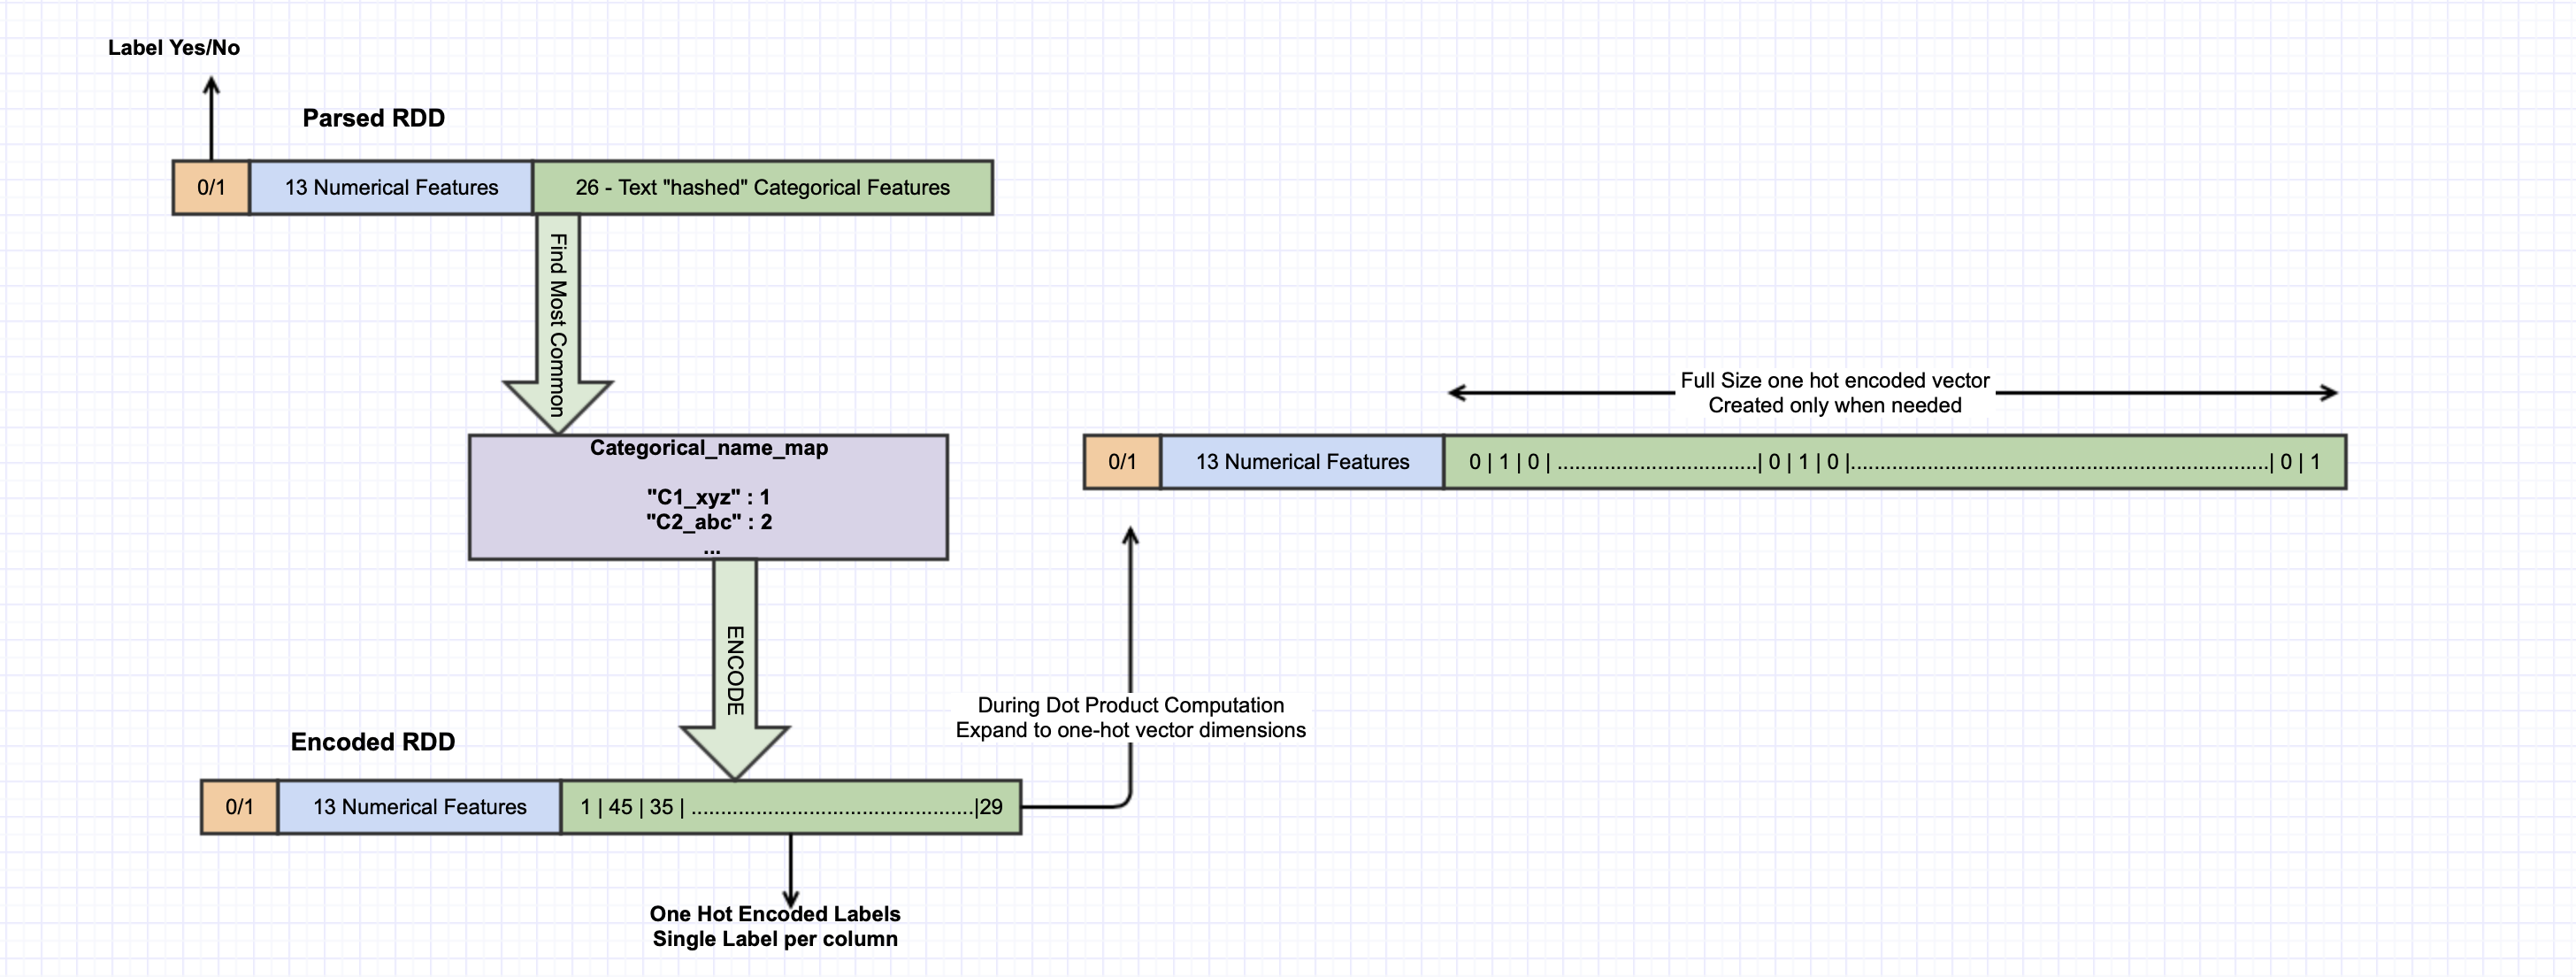

In [1]:
from IPython.display import Image
Image(filename= "one_hot_encoding.png",width="1000",height="600")

As described above, we pick the top 1000 categorical variables by frequency. We also print out the top 20 and bottom 20 of these categorical variables as examples

In [41]:
# Pick the top-k most frequently occuring categorical classes in the training set
top_k = 1000

categorical_names = trainRDD.flatMap(lambda x: [('C{}_{}'.format(col,var),1) for col,var in enumerate(x[1][1])] ) \
                              .reduceByKey(lambda x,y: x+y ) \
                              .takeOrdered(top_k,lambda x:-x[1])

In [42]:
# Print the top 20 names and occurrances

pp.pprint(categorical_names[:20])

[   ('C8_a73ee510', 18408809),
    ('C21_MISSING', 15200636),
    ('C4_25c83c98', 13502834),
    ('C7_0b153874', 11951650),
    ('C0_05db9164', 10073528),
    ('C16_e5ba7672', 9898488),
    ('C19_MISSING', 8983344),
    ('C25_MISSING', 8983344),
    ('C24_MISSING', 8983344),
    ('C18_MISSING', 8983344),
    ('C22_32c7478e', 8980539),
    ('C5_7e0ccccf', 7912164),
    ('C13_07d13a8f', 7062519),
    ('C18_21ddcdc9', 6736361),
    ('C13_b28479f6', 6712505),
    ('C5_fbad5c96', 4355150),
    ('C9_3b08e48b', 4205373),
    ('C19_b1252a9d', 3937771),
    ('C22_3a171ecb', 3861753),
    ('C5_fe6b92e5', 3762247)]


In [43]:
# Print the bottom 20 names and occurances

pp.pprint(categorical_names[-20:])

[   ('C20_780bdc55', 38902),
    ('C3_6bb5a9c4', 38902),
    ('C14_586a2aab', 38836),
    ('C17_2ae4f30d', 38813),
    ('C1_d4be07ad', 38797),
    ('C17_cbae5931', 38797),
    ('C3_4e353d3a', 38715),
    ('C20_e5195a68', 38715),
    ('C23_9be5c7a4', 38715),
    ('C15_5f704016', 38715),
    ('C2_4b0ad917', 38715),
    ('C11_ce2957ad', 38715),
    ('C10_a4ea009a', 38605),
    ('C12_1e9339bc', 38605),
    ('C17_e96a7df2', 38582),
    ('C6_6f441cf5', 38433),
    ('C6_d5f62b87', 38411),
    ('C4_2c6b8ded', 38363),
    ('C23_38be899f', 38312),
    ('C18_f30f7842', 38293)]


In [44]:
#There are 27 empty indices, one per categorical column in addition to the ones picked above

categorical_name_map = {var[0]:i+27 for i,var in enumerate(categorical_names)}
for i in range(27):
    categorical_name_map['C{}_rare'.format(i)] = i

The categorical variables we retain are mapped to unique indices and stored in the `categorical_name_map`. This is a lightweight data-structure containing only 1026 entries in our setup. This is then broadcast to all spark executers via the **broadcasting** mechanism. This way all the input data RDD's can be transformed from using text features to RDDs containing categorical features encoded as their one-hot indices.

In [45]:
# Broadcast the categorical name dictionary
categorical_name_map = sc.broadcast(categorical_name_map)

# Broadcast the size of the categorical name dictionary
categorical_map_size = sc.broadcast(len(categorical_name_map.value) + 1)

In [46]:
def generate_cat_ids(cat_str):
    """
       Input   : A list containing all the text based categorical features
       Returns : The one hot index corresponding to each of the passed text feature
       
       This function is responsible for converting the text based features stored in each
       row of the RDD to its corresponding one-hot index. It uses the broadcasted variable
       'categorical_name_map' to do the lookup from the text feature name to its index.
       
    """
    # first allocate np array for feature size len. There are 26 categorical feature columns
    feature_ids = np.zeros(26,dtype= int)
    for col,feature in enumerate(cat_str):
        # each column has an empty index
        idx = categorical_name_map.value.get("C{}_{}".format(col,feature),col)
        feature_ids[col] = idx
    return feature_ids

In [47]:
def generate_cat_array(feature_ids):
    """
    Input : Set of indices representing the categorical features
    Output: An expanded one-hot vector which 1's in the feature-index 
            poisitions and 0's elsewhere
            
    This function is used to expand out the categorical indices to a full sized one-hot encoded vector
    It is called when a dot product needs to be performed between the model weights and the features
    """
    
    # first allocate np array for feature size len
    feature_arr = np.zeros(categorical_map_size.value,dtype= int)
    for feature_idx in feature_ids:
        feature_arr[feature_idx] = 1
    return feature_arr

In [48]:
# Encode the categorical variables with their one-hot indices. Sample to check the format

train_RDD = trainRDD.map(lambda x: (x[0],(x[1][0], generate_cat_ids(x[1][1]) ) )).cache()
val_RDD = valRDD.map(lambda x: (x[0],(x[1][0], generate_cat_ids(x[1][1]) ) )).cache()
test_RDD = testRDD.map(lambda x: (x[0],(x[1][0], generate_cat_ids(x[1][1]) ) )).cache()
train_RDD.take(1)

[(1,
  ([-0.16840408742427826,
    -0.26371270418167114,
    -0.059690847992897034,
    0.5168978571891785,
    -0.2571341097354889,
    0.21203991770744324,
    -0.11618812382221222,
    0.9157631397247314,
    0.35560697317123413,
    -0.9161503314971924,
    0.25858378410339355,
    -0.20295080542564392,
    0.05853796750307083],
   array([148, 155, 228, 226,  51,  38,   6,  50,  27,   9, 403, 227, 397,
           41, 378, 225,  32, 334,  36,  33, 224,  28,  45, 223,  35,  34])))]

## 4.3 Logistic Regression

In Logistic Regression, the goal is to predict the probability of the output ($\boldsymbol{\hat{y}}$) being 1 or 0, based on the values of the input variables($\boldsymbol{x}$).    
The model is formally defined as a log ratio of the output variable ($\hat{y} = 1$) vs ($\hat{y} = 0$) being a linear combination of it's input variable.

\begin{equation}
     log \left ( \frac{\hat{y}=1}{\hat{y}=0} \right ) = w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + \ldots + w_n \cdot x_n
\end{equation}

which can be transformed, to the alternative formulation, which is also referred to as the sigmoid function:

\begin{equation}
     P(\hat{y}=1) =  \frac{1}{1 + e^{-(w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + \ldots + w_n \cdot x_n)}}
\end{equation}

For the regression model to be trained we need a loss function which is differentiable. The model is trained via a gradient update mechanism, the gradient being defined as the sensitivity(via derivative) of the loss function with respect to the model parameters(refered to as weights in the following code).

We use the conventional log loss metric as our loss function. It is defined as stated below:

\begin{equation}
LogLoss = J(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}(-\boldsymbol{y} \cdot log(\hat{\boldsymbol{y}}) - (1-\boldsymbol{y}) \cdot log(1- \boldsymbol{\hat{y}}))
\end{equation}

where $m$ is the number of rows in our training data, $y$ is the label for the current training example denoting whether the user actually clicked on the ad or not (1 or 0), and $\hat{y}$ is the the predicted probability of the user clicking on that ad for the current training example.

Below is our implementation for the logistic loss function. We first transform the DataRDD to the predictRDD via the sigmoid function. Subsequently, we compute the loss function, comparing the predicted vs labelled values for the click rate.

In [49]:
def LogisticLoss(dataRDD, W):
    """
    Compute the log loss.
    Args:
        dataRDD - each record is a tuple of (y, (int_features_array, cat_feature_array))
        W       - (array) model coefficients with bias at index 0
    """
    
    def calcLoss(y_pred,y_label):
        """
           This helper function is needed to compute the loss function 
           once the predicted value 'y_pred is computed'
           To avoid numerical runoffs at extreme values close to 0 or 1
           we bound the max and min values for y_pred.
        """
        if y_label == 0:
            output = -np.log(1-min(0.999999999999, y_pred ))
        else:
            output = -np.log(max(0.0000000000001, y_pred))
            
        return output
    
    def compute_sigmoid (features,W):
        """
        We compute the sigmoid function here given the features and weights.
        This is called per row of the RDD.
        Before computing we augment the RDD rows with `1` as the first element
        Also we expand the text feature indices to their corresponding one-hot vector
        """
        
        categorical_features = generate_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        # release one-hot vector memory
        del all_features
        return sigmoid
    
    # compute the sigmoid function for prediction followed by the label 
    predictRDD =  dataRDD.map(lambda x: (compute_sigmoid(x[1],W),x[0]))
 
    loss = predictRDD.map(lambda x: calcLoss(x[0],x[1])).mean()
    
    return loss

## 4.4 Logistic Regression Gradient Update

The parameters(or weights) of the Logistic regression model are fit using the gradient update step.
At each gradient update step, we compute the gradient of the loss function, with respect to the model weights, as formulated below.

\begin{equation}
  Gradient = \nabla_{\boldsymbol{W}} f(\boldsymbol{W}) = \frac{1}{m} \cdot \sum_{i=1}^{m}\boldsymbol{x'} \cdot (\boldsymbol{\hat{y}} - \boldsymbol{y})
\end{equation}

The above equation essentially computes a weighted sum of the data points with the corresponding error in prediction as the weights.
Once the gradient is computed for a step, we adjust the model parameters $W$, as per the equation below:

\begin{equation}
 W = W - learningRate \cdot \nabla_{\boldsymbol{W}} f(\boldsymbol{W})
\end{equation}

The learning rate is a hyper-parameter to be tuned w.r.t to the validation set accuracy.

Below is our Spark implementation of the single. Gradient Update Step. For generality, we also pass a regularization type (regType) parameter along with a tuning factor(regParam) to this function which are described in greater depth in section 4.6.

In [50]:
def GDUpdate(dataRDD, W, learning_rate = 0.2, regType = None, regParam = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, (int_features_array, cat_features_array))
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    #augmentedData = dataRDD.map(lambda x: ( x[1][0], x[0]))
    
    def compute_sigmoid (features,W):
        categorical_features = generate_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        del all_features
        del categorical_features
        return sigmoid
    
    def dot_with_features(features,delta_predict):
        categorical_features = generate_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        dot_prod = np.dot(all_features,delta_predict)
        del all_features
        del categorical_features
        return dot_prod
        
    
    # compute the features, sigmoid function for prediction followed by the label 
    # here we also keep the original features as they are needed for the grad computation step
    # predictRDD has tuples of shape ((int_features, cat_feature_tokens),(predicted_value, original_label))
    predictRDD =  dataRDD.map(lambda x: (x[1],(compute_sigmoid(x[1],W),x[0])))
 
    # we need to flatten the categorical features before taking the dot product
    grad = predictRDD.map(lambda x: dot_with_features(x[0],x[1][0] - x[1][1])).mean()
    
    #incorporate Reg parameters
    if regType == 'ridge':
        grad[1:] += 2*regParam * W[1:]
    elif regType == 'lasso':
        grad[1:] += regParam * np.sign(W[1:])
    else:
        pass
    
    new_model = W - learning_rate* grad
   
    return new_model

## 4.5 Make Predictions on Validation Set

### 4.5.1 Set Up Baseline

The baseline model gives a starting point for the weights of the Logistic Regression Model. Since our cost function is convex, we do not anticipate convergence issues due to the specific starting point weights. However, we initialize is such that the starting model predicts with the same accuracy as taking the mean of the output variable. In this case that is achieved by making sure that the sigmoid function predicts the probability of the output variable being 0.5. This in turn yeilds a zero initialization value for both the bias terms and the vector of weights.

In [51]:
# mean_clicks = train_RDD.map(lambda x: x[0]).mean() 
BASELINE = np.append(0, np.zeros(len(numeric_fields) - 1 + categorical_map_size.value) )

### 4.5.2 Perform Gradient Descent

In this section, we define 2 helper functions for computing accuracies and plotting error curves followed by the main Gradient Descent Function.
The Gradient Descent Function takes in the training and validation Datasets and runs the gradient update steps for the number of iterations specified. It also takes in optional parameters for learning rate, the regularization type and the regularization parameter. Also, under an optional verbose setting, it displays the training/validation errors per iteration and also plots the error curves at the end of the training steps.

In [52]:
def compute_accuracy(RDDIn,model):
    """
    Given the input RDD and weights corresponding to a regression model,
    computes the model accuracy in terms of the fraction of correct predictions.
    Please note that the RDD is expected to have the correct labels as the first entry
    in each row.
    """
    
    def compute_sigmoid1 (features,W):
        categorical_features = generate_cat_array(features[1])
        all_features = np.concatenate(([1],features[0],categorical_features), axis=-1)
        sigmoid = 1/(1+np.exp(-np.dot(all_features,W)))
        del all_features
        del categorical_features
        return sigmoid
    
    predictRDD =  RDDIn.map(lambda x: (compute_sigmoid1(x[1],model),x[0]))
    accuracy = predictRDD.map(lambda x: (1 if x[0] >= 0.5 else 0, x[1])).map(lambda x: x[0]==x[1]).mean()
    return accuracy

In [53]:
def plotErrorCurves(trainLoss, valLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , valLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, valLoss[1:], 'r--', label='Validation Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log loss Error')
    if title:
        plt.title(title)
    plt.show()

In [54]:
def GradientDescent(trainRDD, valRDD, wInit, nSteps = 20, learningRate = 0.2,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    output loss on a validation and train set. 
    """
    
    if regType is not None:
        print("Running Gradient Descent with regularization enabled")
    
    # perform n updates & compute val and train loss after each
    model = wInit
    
    train_history, val_history = [], []

    for idx in range(nSteps):  
        # update the model
        print(f"STEP: {idx+1}")
        print("-"*80)
        start_time = time.time()
        model = GDUpdate(trainRDD, model, learningRate, regType, regParam)
        end_time = time.time()
        print("Time taken for gradient update : {0:.2f} mins".format((end_time - start_time)/60))
       
        if verbose:
            start_time = time.time()
            train_loss = LogisticLoss(train_RDD, model)
            end_time = time.time()
            print("Time taken for computing train loss : {0:.2f} mins".format((end_time - start_time)/60))
            print(f"train_Loss: {train_loss:.4f}")
    
            start_time = time.time()
            val_loss = LogisticLoss(val_RDD,model)
            end_time = time.time()
            print("Time taken for computing validation loss : {0:.2f} mins".format((end_time - start_time)/60))
            print(f"val_loss: {val_loss:.4f}")
            
            train_history.append(train_loss)
            val_history.append(val_loss)
    

    accuracy = compute_accuracy(valRDD,model)

    if not verbose:
        train_loss = LogisticLoss(trainRDD, model)
        val_loss = LogisticLoss(valRDD, model)
    
             
    if regType is  None:
        print(f"After {nSteps} iterations, the trainingLogLoss on training set is : {train_loss:.4f}")
    else:
        print((f'After {nSteps} iterations, the {regType} trainLogLoss'
               f'when alpha is {regParam}'
               f'on the training set is: {train_loss:.4f}'))
    
    if regType is  None:
        print(f"After {nSteps} iterations, the valLogLoss on the validation set is : {val_loss:.4f}")
    else:
        print((f"After {nSteps} iterations, the {regType} valLogLoss "
               f"when alpha is {regParam} on the validation set is: {val_loss:.4f}"))
    
    if regType is None:
            print(f"After {nSteps} iterations, the accuracy on the validation set is : {accuracy:.4f}")
    else:
            print((f"After {nSteps} iterations, the {regType} accuracy "
                   f"when alpha is {regParam} on the validation set is: {accuracy:.4f}"))
            
    print('\n')
    
    if verbose:
        if regType == None: 
            regStr= ""
        else:
            regStr = str(regType)
        plotErrorCurves(train_history, val_history, title = f"Logistic Regression {regStr}" )
    
    return train_loss, val_loss, model

STEP: 1
--------------------------------------------------------------------------------
Time taken for gradient update : 2.51 mins
Time taken for computing train loss : 0.89 mins
train_Loss: 0.6881
Time taken for computing validation loss : 0.27 mins
val_loss: 0.6881
STEP: 2
--------------------------------------------------------------------------------
Time taken for gradient update : 1.86 mins
Time taken for computing train loss : 1.01 mins
train_Loss: 0.6839
Time taken for computing validation loss : 0.09 mins
val_loss: 0.6838
STEP: 3
--------------------------------------------------------------------------------
Time taken for gradient update : 2.01 mins
Time taken for computing train loss : 0.98 mins
train_Loss: 0.6802
Time taken for computing validation loss : 0.09 mins
val_loss: 0.6801
STEP: 4
--------------------------------------------------------------------------------
Time taken for gradient update : 1.85 mins
Time taken for computing train loss : 0.97 mins
train_Loss: 0

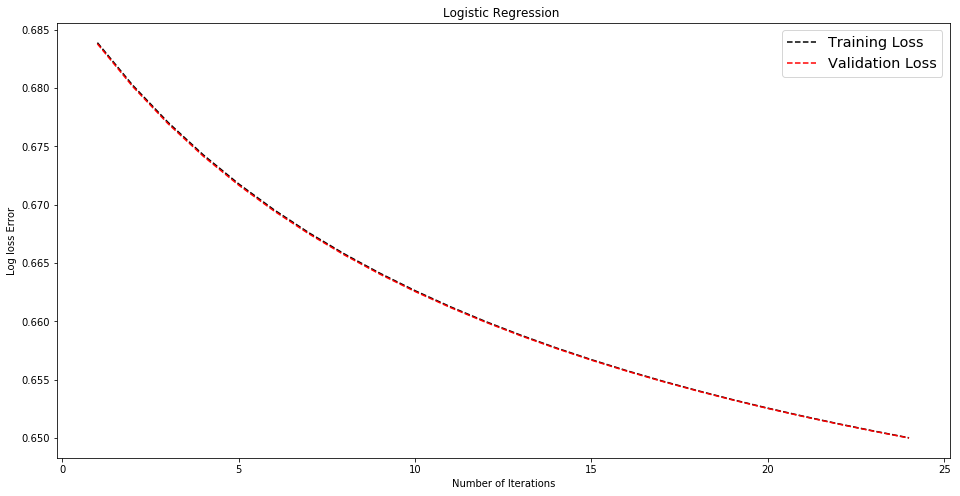

In [55]:
train_loss,val_loss,model = GradientDescent(train_RDD,val_RDD,BASELINE,nSteps=25,verbose=True)

### 4.5.4 Compute Accuracy

In [56]:
accuracy = compute_accuracy(val_RDD,model)
val_log_loss = LogisticLoss(val_RDD,model)
print(f"Model: Validation Accuracy: {accuracy:.4f}")
print(f"Model: Validation Log Loss: {val_log_loss:.4f}")

Model: Validation Accuracy: 0.6453
Model: Validation Log Loss: 0.6500


In [57]:
test_accuracy = compute_accuracy(test_RDD,model)
test_log_loss = LogisticLoss(test_RDD,model)
print(f"Model: Test Accuracy: {test_accuracy:.4f}")
print(f"Model: Test Log Loss: {test_log_loss:.4f}")

Model: Test Accuracy: 0.6454
Model: Test Log Loss: 0.6500


## 4.6 Regularization

After evaluating the log-loss and accuracy on our held-out test set, the team brainstormed how we could further improve our logistic regression model. Ideally, this could be achieved by discovering the right combination of  features to optimize how well our model generalizes to new data. To try and achieve this in an efficient manner, our team tested out the addition of a regularization parameter to our objective function. Specifically, we explored both L1 (Lasso) and L2 (Ridge) regularization for logistic regression models:

>**L2 Regularization (Ridge)**  

\begin{equation}
LogLoss = J(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}(-\boldsymbol{y} \cdot log(\hat{\boldsymbol{y}}) - (1-\boldsymbol{y}) \cdot log(1- \boldsymbol{\hat{y}})) + \lambda \sum_{j=1}^{m}w_j^2
\end{equation}

\begin{equation}
  Gradient = \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}\boldsymbol{x'} \cdot (\boldsymbol{\hat{y}} - \boldsymbol{y}) + [2*\lambda \sum_{j=1}^{m}w_j]
\end{equation}


>**L1 Regularization (Lasso)**  

\begin{equation}
LogLoss = J(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}(-\boldsymbol{y} \cdot log(\hat{\boldsymbol{y}}) - (1-\boldsymbol{y}) \cdot log(1- \boldsymbol{\hat{y}})) + \lambda \sum_{j=1}^{m}|w_j|
\end{equation}  

\begin{equation}
  Gradient = \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{1}{m} \cdot \sum_{i=1}^{m}\boldsymbol{x'} \cdot (\boldsymbol{\hat{y}} - \boldsymbol{y}) +  \lambda \sum_{j=1}^{m}\dfrac{w_j}{|w_j|}
\end{equation}


To discover the optimal regularization parameters for both a ridge and lasso model, the team utilized a grid-search approach to brute-force test different hyperparameters. Our grid-search included 15 different possible $\lambda$ values; this evaluation tactic was conducted on a smaller sample of the training set with fewer iterations, due to the computational cost of brute-force testing on a dataset this large.

In [ ]:
#Testing different regularization params for Ridge
#DO NOT RUN ON FULL DATASET - COMPUTATIONALLY EXPENSIVE - commented out for that reason

# model = BASELINE
# reg_params = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3] 
# for i in reg_params:
#     GradientDescent(train_RDD, val_RDD, model, nSteps = 10, learningRate = 0.2,
#                          regType = 'ridge', regParam = i, verbose = False)
#     model = BASELINE

In [ ]:
#Testing different regularization params for Lasso

#DO NOT RUN ON FULL DATASET - COMPUTATIONALLY EXPENSIVE - commented out for that reason

# model = BASELINE
# reg_params = [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5] 
# for i in reg_params:
#     GradientDescent(train_RDD, val_RDD, model, nSteps = 10, learningRate = 0.2,
#                          regType = 'lasso', regParam = i, verbose = False)
#     model = BASELINE

This exercise led to the team utilizing a regularization parameter of $\lambda = 0.01$ for ridge and $\lambda = 0.0001$ for lasso. The team evaluated both a lasso model and a ridge model on the full dataset with these optimal penalty terms.

In [58]:
#Evaluate full dataset with best hyperparameter for ridge
model = BASELINE
Ridge_LogLossTrain, Ridge_LogLossVal, RidgeModel  = GradientDescent(train_RDD, val_RDD, model, nSteps = 25, learningRate = 0.2,
                         regType = 'ridge', regParam = 0.01, verbose = False)

Running Gradient Descent with regularization enabled
STEP: 1
--------------------------------------------------------------------------------
Time taken for gradient update : 1.71 mins
STEP: 2
--------------------------------------------------------------------------------
Time taken for gradient update : 1.84 mins
STEP: 3
--------------------------------------------------------------------------------
Time taken for gradient update : 1.68 mins
STEP: 4
--------------------------------------------------------------------------------
Time taken for gradient update : 1.77 mins
STEP: 5
--------------------------------------------------------------------------------
Time taken for gradient update : 1.66 mins
STEP: 6
--------------------------------------------------------------------------------
Time taken for gradient update : 1.82 mins
STEP: 7
--------------------------------------------------------------------------------
Time taken for gradient update : 1.67 mins
STEP: 8
---------------

In [60]:
#Evaluate full dataset with best hyperparameter for lasso
model = BASELINE
Lasso_LogLossTrain, Lasso_LogLossVal, LassoModel = GradientDescent(train_RDD, val_RDD, model, nSteps = 25, learningRate = 0.2,
                         regType = 'lasso', regParam = 0.0001, verbose = False)

Running Gradient Descent with regularization enabled
STEP: 1
--------------------------------------------------------------------------------
Time taken for gradient update : 1.70 mins
STEP: 2
--------------------------------------------------------------------------------
Time taken for gradient update : 1.71 mins
STEP: 3
--------------------------------------------------------------------------------
Time taken for gradient update : 1.83 mins
STEP: 4
--------------------------------------------------------------------------------
Time taken for gradient update : 1.70 mins
STEP: 5
--------------------------------------------------------------------------------
Time taken for gradient update : 1.67 mins
STEP: 6
--------------------------------------------------------------------------------
Time taken for gradient update : 1.83 mins
STEP: 7
--------------------------------------------------------------------------------
Time taken for gradient update : 1.70 mins
STEP: 8
---------------

In [59]:
#Evaluate Loss and Accuracy on test data for Ridge
test_ridge_accuracy = compute_accuracy(test_RDD, RidgeModel)
test_ridge_log_loss = LogisticLoss(test_RDD, RidgeModel)
print(f"Ridge Model: Test Accuracy: {test_ridge_accuracy:.4f}")
print(f"Ridge Model: Test Log Loss: {test_ridge_log_loss:.4f}")

Ridge Model: Test Accuracy: 0.6454
Ridge Model: Test Log Loss: 0.6509


In [61]:
#Evaluate Loss and Accuracy on test data for Lasso
test_lasso_accuracy = compute_accuracy(test_RDD, LassoModel)
test_lasso_log_loss = LogisticLoss(test_RDD, LassoModel)
print(f"Lasso Model: Test Accuracy: {test_lasso_accuracy:.4f}")
print(f"Lasso Model: Test Log Loss: {test_lasso_log_loss:.4f}")

Lasso Model: Test Accuracy: 0.6453
Lasso Model: Test Log Loss: 0.6502


Based on our output above, incorporating an L1 and L2 penalty into our logistic regression model does not result in any meaningful improvements in the log-loss and accuracy for the test data. This finding suggests that our logistic regression model is more likely underfitting than overfitting the training data, as the generalizability of our model is rather consistent with what we were seeing for our unregularized model. To see an improvement in both accuracy and log-loss, it would likely require adding more complexity to the model, such as including terms to capture the interactions between features. This is a model enhancement the team is interested in exploring more in the future.

## 4.7 Experiments

Before concluding with a summary of some the major course concepts our team utilized in this project, we have provided a snippet below detailing some of the experiments we ran when evaluating our logistic regression models. These experiments highlight our interest in exploring different implementations of logistic regression, and how these different variations perform with regards to model accuracy 


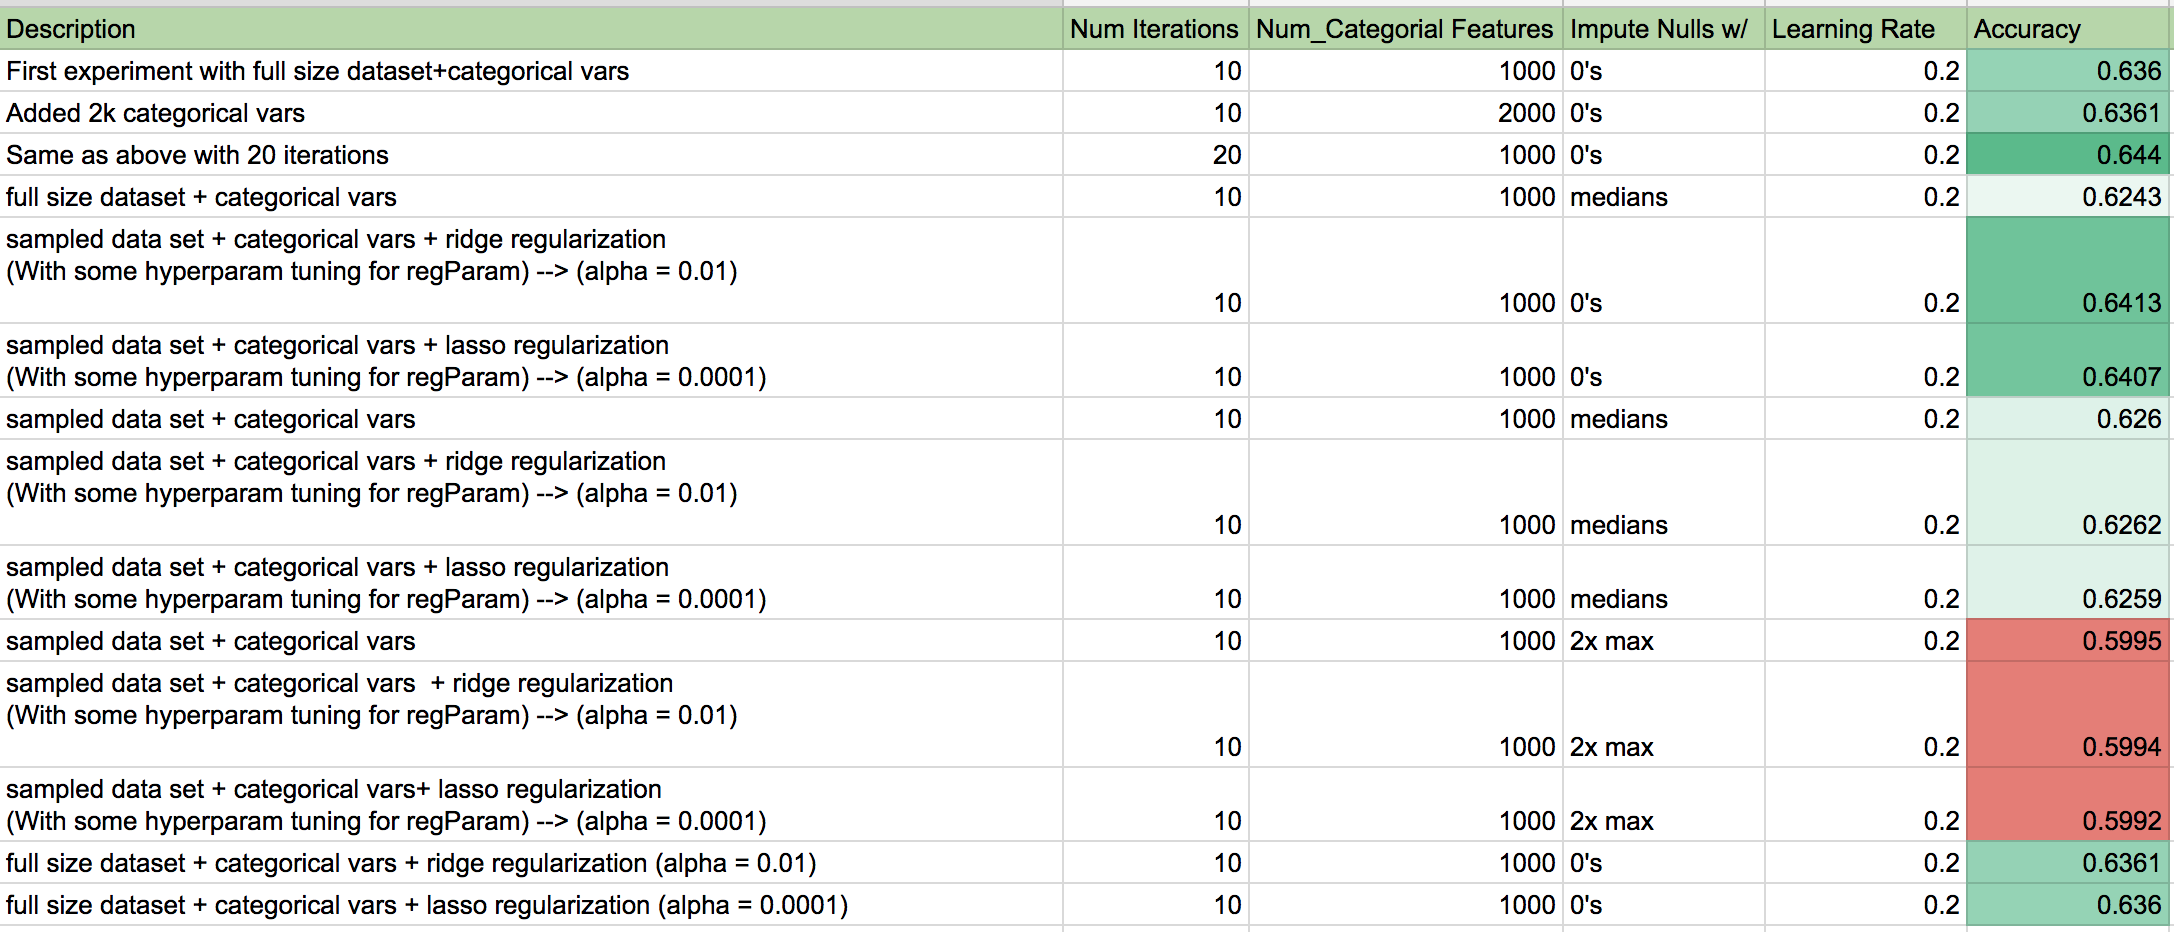

In [6]:
Image(filename='Experiments_spreadsheet.png',width="1000",height="600")

## 5. Application of Course Concepts

We were able to achieve the above results by implementing an approach that carefully considered several key concepts from this course material. In general, the large size of the dataset (approximately 46 million rows) necessitates a solution that was scalable and parallelizable. To achieve this goal, we employed several techniques to support more efficient processing at a faster rate. 

After conducting EDA, we determined that binary logistic regression was the most appropriate approach to predicting whether an advertisement was clicked or not, because its output is the probability that a given input point belongs to one of two classes (in this case, "clicked" or "not clicked"). 

To use this approach, we had to do some feature engineering to replace null values, normalize our input values, and one-hot encode the 26 categorical features. The numeric features were on differing scales, the smallest scale is from 0 to 4 and the largest is from 0 to 1,000,000. This would be problematic for gradient descent, because when the features are not of the same scale, it may take a long time to find the global minimum. Instead of moving "down the mountain," we would oscillate back and forth slowly toward the minimum. It's not necessarily impossible to still find the minimum, but it'd definitely take a long time. Thus, we normalized all of the values, so we were able to find the minimum more quickly. This is especially important when completing gradient descent at scale because each step is computationally expensive with the volume of data we are using. We normalized each feature so that all values are between 0 and 1. It's worth noting that this process itself is computationally rather expensive, because we must calculate the mean and standard deviation of teh millions of values for each of the 13 numeric features. Then, we broadcast the means and standard deviations of the features to make one more pass over the data to transform the values into normalized values.

Another important step in our feature engineering was to one-hot encode the 26 categorical features so that they could be used in logistic regression. Some machine learning algorithms, such as Decision Trees, are able to handle categorical features as-is, but logistic regression cannot and thus we must find an approach to one-hot encode them. This proved to be a difficult task. If we were to one-hot encode every value for every categorical feature in our dataset, we would end up with over 33 million columns, and very sparse rows. This would be a memory problem, as those become very large representations. Instead, we first perform some feature selection to identify the top 1000 most common categorical features across all categories, and classify all other features in the same "rare" category. Then, we have a denser representation, and a much smaller data structure. Additionally, we encoded this information in a dictionary of categorical features, like a stripe. This data structure allows us to keep track of all the same information from those vectors with less memory overhead because we don't encode all the zeros, instead we just store the non-zero entries. We then only expanded the information to generate the sparse one-hot encoded vectors when we used them for computing the sigmoid function, and unpersisted them after calculations to free up memory. 

Spark's lazy evaluation is key to the scalability of our approach as well. Since Spark does not begin computing the partitions until an action is called, it takes care of combining mapping operations that don't require communication with the driver. This avoids doing multiple passes for multiple narrow transformations (such as maps or map + filter), instead, they can all be done at the same time and then the records are only accessed once. This reduced computational complexity, which is very important when working with a dataset of this scale.

Of course, one of the negative side effects of lazy evaluation is that throughout the development process, debugging was more difficult because Spark only fails at the point of action, like count/collect. Only at that point does Spark trigger the scheduler to build a directed acyclic graph (DAG) based on the dependencies between RDD transformations. However, we were able to use the Spark DAG UI to understand how to streamline our implementation.

One way that we did this was by adding `cache()` statements throughout our implementation, avoiding many redundant shuffles. And, `cache()` is an action, so Spark actually begins computation. This was useful when we were completing multiple actions on the same RDD, so we were able to reuse our RDDs without repeating calculations that already occurred. In particular, caching is useful for iterative computations like gradient descent, like in our approach, where we are iterating numerous times over the same RDD. We saw a decrease in the time to compute the gradient from 2.51 minutes to 1.86 minutes after the first iteration, after the RDD was cached.

Another way that we increased efficiency was by broadcasting variables. In particular, we broadcasted our categorical feature dictionary so that it could be referenced by all nodes. This way, instead of a copy of the dictionary being distributed with each task, to all partitions, it was only distributed once to each node. Broadcast variables need to fit in memory on one machine and be immutable, so this dictionary is well-suited to be broadcasted, because it was not very large and was used simply for lookups when creating our one-hot encoded vectors. 

The implementation decisions described above allowed us to complete logistic regression and gradient descent. For logistic regression, we used the sigmoid function to predict a probability that a datapoint was in a particular class. To find the best values for the weights of this function, we took the derivative to obtain the loss function, which we then sought to minimize. This is a convex function, meaning that its derivative (the second derivative of the sigmoid function) never changes sign. This is particularly helpful for computing the loss, because the error surface is always curving in the same direction, guaranteeing that any minimum we find is in fact the global minimum. We iteratively updated the weights of our model to find the weights that minimized the loss for our best model. We also explored using L1 (lasso) and L2 (ridge) regularization techniques to improve the generalizability of our model and prevent overfitting. However, neither approach seemed to affect performance in any measurable way.

Ultimately, we achieved a log loss of 0.650 and accuracy of 0.645 on both the validation and test sets after 25 iterations of gradient descent with our "homegrown" approach to logistic regression. Thus, we achieved our accuracy goal of at least 60%, and barely met our log loss goal of less than 0.693. The most impactful adjustments to our hyperparameters on performance were increasing the number of iterations of gradient descent and imputing the null values with 0 rather than medians or max values. This is encouraging, but it suggests that a further developed approach may also be effective and improve our performance. For example, since our regularization results indicate that our model is underfitting the training data, we could increase the complexity of our model by including terms to capture the interaction between features. In addition, we could explore using other machine learning algorithms, such as decision trees, to see if they are able to obtain better performance. Or, an ensemble approach may prove to be most effective, given the scale and complexity of this dataset. 